In [106]:
import pandas as pd # for the bulk of the analysis
import numpy as np # for some data transformations
import requests # for the API calls
from datetime import datetime # it became clear during analysis that this is more suitable for working with timestamps than the built in datetime functions of pandas.
import seaborn as sns # for visualising the exploratory data analysis and model results
import matplotlib.pyplot as plt # for supporting seaborn
import matplotlib.dates as mdates
import folium as fm # for mapping the locations
from scipy.stats import ttest_ind, pearsonr # for testing relationships between cycling counts and weather variables
import sys 
import os

# Various sklearn modules used in model creation and validation
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA

pd.options.mode.chained_assignment = None

# Data familiarisation

There are three types of cycling count data - cycleway counts', strategic counts and central london counts. These are therefore compared (using 2022 as an example) to check they are the same format. Investigating the columns shows they are identical which means dataframes from different categories can be concatenated, athough we add a type column so we can see which dataset each record comes from later (after concatenating)

In [107]:
central_2022=pd.read_csv('central_counts/2022 Q1 (January-March).csv')
central_2022['type']='central'
strat_2022=pd.concat([pd.read_csv('strat_counts/2022-Central.csv'),
                      pd.read_csv('strat_counts/2022-Outer.csv'),
                      pd.read_csv('strat_counts/2022-Inner-Part1.csv'), 
                      pd.read_csv('strat_counts/2022-Inner-Part2.csv')])
strat_2022['type']='strat'
cycleway_2022=pd.concat([pd.read_csv('cycleway_counts/2022-2-autumn.csv'),
                        pd.read_csv('cycleway_counts/2022-1-spring.csv')])
cycleway_2022['type']='cycleway'
dfs=[central_2022, strat_2022, cycleway_2022]
for df in dfs:
    print(df.columns)


Index(['Year', 'UnqID', 'Date', 'Weather', 'Time', 'Day', 'Round', 'Dir',
       'Path', 'Mode', 'Count', 'type'],
      dtype='object')
Index(['Year', 'UnqID', 'Date', 'Weather', 'Time', 'Day', 'Round', 'Dir',
       'Path', 'Mode', 'Count', 'type'],
      dtype='object')
Index(['Year', 'UnqID', 'Date', 'Weather', 'Time', 'Day', 'Round', 'Dir',
       'Path', 'Mode', 'Count', 'type'],
      dtype='object')


Try to get a sense of how much data there is to inform a sampling strategy for exploring trends as the full dataset would be extremely large

In [108]:
counter=0
for df in dfs:
    print(len(df))
    counter += len(df)
print(f"Total: {counter:,}")

52992
2211584
73856
Total: 2,338,432


# Initial preprocessing

To get a better sense of things, first concatenate all the 2022 dataframes, create a Datetime object from the date and time column and then remove the date, time, year and day columns as they are now redundant.  Use head just to check this has worked.  

In [109]:
all_2022=pd.concat(dfs)
all_2022['Datetime']=all_2022.Date.astype(str) + " " + all_2022.Time.astype(str)
all_2022['Datetime']=pd.to_datetime(all_2022['Datetime'], format = "%d/%m/%Y %H:%M:%S")
all_2022=all_2022.drop(['Date', 'Time', 'Year', 'Day'], axis=1)
all_2022.head()

,UnqID,Weather,Round,Dir,Path,Mode,Count,type,Datetime
0,CENCY001,Dry,A,Northbound,NaN,Private cycles,12,central,2022-03-07 06:00:00
1,CENCY001,Dry,A,Northbound,NaN,Private cycles,43,central,2022-03-07 06:15:00
2,CENCY001,Dry,A,Northbound,NaN,Private cycles,64,central,2022-03-07 06:30:00
3,CENCY001,Dry,A,Northbound,NaN,Private cycles,77,central,2022-03-07 06:45:00
4,CENCY001,Dry,A,Northbound,NaN,Private cycles,116,central,2022-03-07 07:00:00


Now groupby month to get a better sense of how data is spread throughout the year. The data documentation highlights that the strategic counts are carried out from April to July, and this monthly analysis shows that these months dominate since there are far more strategic counts than others.  We can also see the file is huge

In [110]:
by_month=all_2022.groupby(pd.Grouper(key='Datetime', freq = 'M')).type.value_counts()
print(by_month.head(12))
print(sys.getsizeof(all_2022))

Datetime    type    
2021-12-31  central         64
2022-01-31  central      15056
2022-02-28  central      18668
2022-03-31  central      18788
2022-04-30  strat       122112
            central        416
2022-05-31  strat       671616
            cycleway      9288
2022-06-30  strat       726528
            cycleway     12040
2022-07-31  strat       691328
            cycleway      4784
Name: count, dtype: int64
1118165536


The focus of this analysis is on the weather. Therefore, while some other columns in the TfL data may be useful as attributes we'll want to remove some columns that are unlikely to be used for analysis to simplify the data as it will allow rows to be combined by aggregating across removed variables. Therefore do a quick check of value counts to see if it is likely to be useful e.g. if there are columns with mostly the same value, they may not have much analytical value. 

In [111]:
cols=['Weather', 'Round', 'Dir', 'Path', 'Mode']
# for col in cols:
#     print(all_2022[col].value_counts(normalize=True))

Based on this, the 'round' column is removed. It also shows the path column needs cleaning as some include direction which is already covered in the 'dir' column.  The mode column also includes some motorised transport - these rows are removed. 

In [112]:
to_remove=['Coaches', 'Buses', 'Taxis', 'Motorcycles', 'Medium goods vehicles', 'Light goods vehicles', 
           'Heavy goods vehicles', 'Cars']
all_2022=all_2022[~all_2022['Mode'].isin(to_remove)]
all_20222=all_2022.drop(columns=['Round'])
all_2022['Path'] = all_2022.Path.replace(" - \w*", "", regex=True)
all_2022.head()



,UnqID,Weather,Round,Dir,Path,Mode,Count,type,Datetime
0,CENCY001,Dry,A,Northbound,NaN,Private cycles,12,central,2022-03-07 06:00:00
1,CENCY001,Dry,A,Northbound,NaN,Private cycles,43,central,2022-03-07 06:15:00
2,CENCY001,Dry,A,Northbound,NaN,Private cycles,64,central,2022-03-07 06:30:00
3,CENCY001,Dry,A,Northbound,NaN,Private cycles,77,central,2022-03-07 06:45:00
4,CENCY001,Dry,A,Northbound,NaN,Private cycles,116,central,2022-03-07 07:00:00


Further investigation of Mode, aggreated for all the 2022 data, indicates that a) for some modes the median count is zero/ mean is extremely low and b) the different datasets use different categories.  The release notes show that pre-2022 the strat counts (main dataset) had private and hire for central and inner, and male v female for outer. This has now been standardised. i.e. 2022 data is better but we are looking beyond this. Clearly the value of this variable is greatly reduced if the categories are not consistent across the data files we have merged.  

In [113]:
pd.concat([all_2022.groupby(['Mode', 'type']).Count.median(), 
          all_2022.groupby(['Mode', 'type']).Count.mean()], axis=1)

Count      Count
Mode                type                      
Cargo bikes         strat       0.0   0.018049
Conventional cycles strat       0.0   3.066405
Cycle hire bikes    central     1.0   1.974977
                    cycleway    0.0   0.735193
                    strat       5.0   6.500000
Cycles              cycleway   11.0  21.043478
E-scooters          strat       0.0   0.095216
Female cyclists     cycleway    0.0   1.154105
Male cyclists       cycleway    2.0   4.030331
Pedestrians         strat       2.0  10.744225
Private cycles      central     8.0  14.932443
                    cycleway    4.0  11.121429
                    strat      40.0  59.617188
Unknown cyclists    cycleway    0.0   0.021599

Mode is therefore removed, and counts can be aggregated across the remaining columns i.e. if all other columns other than mode and count were previously equal, removing mode means we now have duplicate entries other than the count, so just need to add these all up to get the total number of cycles at that time, location etc. This greatly reduces the size of the dataset and the aggregation means there are far fewer zeroes which will make drawing a sample more simple with fewer datapoints to deal with. 

In [114]:
no_mode=all_2022.drop(['Mode'],axis=1).groupby(
    ['UnqID', 'Weather', 'Round', 'Dir', 'Path', 'type', 'Datetime']
, as_index=False ).Count.sum()
print(f"{len(no_mode)} total records, {len(no_mode[no_mode.Count>0])} records with count>0")

387351 total records, 314535 records with count>0


Before progressing further and testing the weather API, we carry out a basic check of the likely influence of weather and look at counts by weather as per the TfL data (which is either 'dry' or 'wet'.  If there is no difference the project may be of limited value. For this purpose we can aggregate all locations, and it suggests weather is a factor as expected

Dry count     2836.000000
mean      2521.017630
std       2615.227854
min          0.000000
25%        421.000000
50%       1841.000000
75%       3665.250000
max      14831.000000
Name: Count, dtype: float64
Wet count      418.000000
mean      1413.956938
std       2069.076932
min          0.000000
25%        101.000000
50%        619.000000
75%       1775.750000
max      13927.000000
Name: Count, dtype: float64


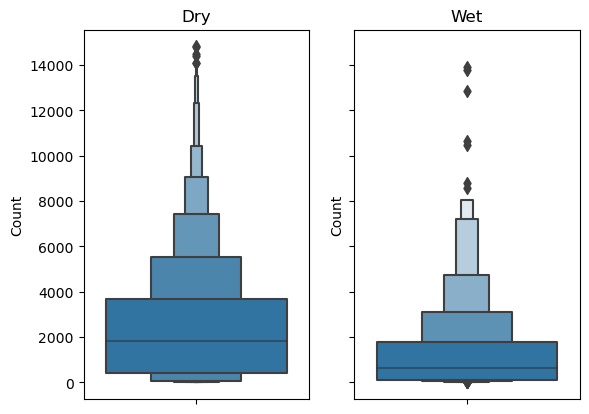

In [115]:
by_time=no_mode.groupby(['Datetime', 'Weather']).Count.sum().reset_index()

fig, ax=plt.subplots(1,2, sharey=True)
sns.boxenplot(y=by_time[by_time.Weather=='Dry'].Count, ax=ax[0]).set(title='Dry')
sns.boxenplot(y=by_time[by_time.Weather=='Wet'].Count, ax=ax[1]).set(title='Wet')

print("Dry", by_time[by_time.Weather=='Dry'].Count.describe())
print("Wet", by_time[by_time.Weather=='Wet'].Count.describe())

Visualise the site locations to see the spread

In [116]:
locations=pd.read_csv('Release notes/0-Count locations.csv')
m = fm.Map(location = (51.5081, 0.1248), tiles="cartodb positron")
locations.apply(lambda row:fm.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                              radius=1, fill=True, opacity=0.3)
                                             .add_to(m), axis=1)
m

# Adding weather data

Next the weather API is tested with an example call, using the time and location of the first row of the 2022 data.  Experimentation showed the timestamp needed to be divided to take it from nano seconds to seconds 

In [117]:
locations=pd.read_csv('Release notes/0-Count locations.csv')

endpoint="https://api.openweathermap.org/data/3.0/onecall/timemachine"
payload= {'lat': locations.Latitude[0], 
          'lon':  locations.Longitude[0],
          'dt': int(no_mode.Datetime.astype(np.int64)[0]/1000000000),
          'appid': '71c2d76da97dd7ef7767e1e43458c53c'}

r=requests.get(endpoint, params=payload)

print(r.status_code)
weath_test=pd.json_normalize(r.json()['data'][0])
# weath_test=pd.concat([weath_test, weath_test])
weath_test


200


,dt,sunrise,sunset,temp,feels_like,pressure,humidity,dew_point,clouds,visibility,wind_speed,wind_deg,weather
0,1657692000,1657684701,1657743220,294.72,294.55,1022,62,287.14,31,10000,3.09,300,"[{'id': 802, 'main': 'Clouds', 'description': ..."


The single call test was successful. However, the analysis requires fetching weather data from  many rows of a dataframe. A small sample is created to test this - first the Latitude and Longitude are added from the locations spreadsheet, and the timestamp is created from the Datetime object

In [118]:
sample=no_mode.sample(50)
sample=sample.merge(locations[['Site ID', 'Latitude', 'Longitude']], left_on='UnqID', 
                    right_on='Site ID').drop(['Site ID'], axis=1)
sample['timestamp']=int(sample.Datetime.astype(np.int64)[0]/1000000000)

We then create a function that takes the latitude, longitude and timestamp to pass to the API and get weather information for a given row.  The function is then applied to the sample dataframe - initially the API return appears as a dictionary in the weather column, but this is then split across columns using the .tolist() command. 

In [119]:
cols=['sunrise', 'sunset', 'temp', 'wind_speed', 'wind_deg', 'visibility', 'clouds','rain', 'weather']
def get_weather_(lat, lon, timestamp):
    payload= {'lat': lat, 
          'lon':  lon,
          'dt': timestamp,
          'appid': '71c2d76da97dd7ef7767e1e43458c53c'}
    resp= requests.get(endpoint, params=payload)
    weath=resp.json()['data'][0]
    for col in cols:
        if col not in weath:
            weath[col]=None

    return [weath[col] for col in cols]
        
sample['weather']=sample.apply(
   lambda row: get_weather(row['Latitude'], row['Longitude'], row['timestamp']), axis=1)

sample[cols]= pd.DataFrame(sample.weather.tolist())
sample.head()

,UnqID,Weather,Round,Dir,Path,type,Datetime,Count,Latitude,Longitude,timestamp,weather,sunrise,sunset,temp,wind_speed,wind_deg,visibility,clouds,rain
0,OUTCY228,Dry,A,Southbound,Pavement,strat,2022-07-04 16:30:00,10,51.424289,-0.013576,1656952200,"[{'id': 803, 'main': 'Clouds', 'description': ...",1656906576,1656965935,294.52,4.63,250,10000.0,75,None
1,INNCY403,Dry,A,Northbound,Carriageway,strat,2022-07-07 09:30:00,0,51.509670,-0.239603,1656952200,"[{'id': 803, 'main': 'Clouds', 'description': ...",1656906603,1656966017,295.20,5.14,260,10000.0,75,None
2,INNCY029,Dry,A,Southbound,Pavement,strat,2022-07-12 08:00:00,32,51.465401,-0.188270,1656952200,"[{'id': 803, 'main': 'Clouds', 'description': ...",1656906605,1656965990,295.12,5.14,260,10000.0,75,None
3,CSHCY051,Dry,A,Eastbound,Cycle lane,strat,2022-05-16 21:45:00,23,51.477939,-0.102563,1656952200,"[{'id': 803, 'main': 'Clouds', 'description': ...",1656906580,1656965974,294.69,4.63,250,10000.0,75,None
4,OUTCY019,Dry,A,Northbound,Carriageway,strat,2022-05-25 09:00:00,2,51.483027,0.062113,1656952200,"[{'id': 803, 'main': 'Clouds', 'description': ...",1656906539,1656965936,294.83,4.63,250,10000.0,75,None


Having got this to work, we can create a function that takes a dataframe as the input.  However, the result of the API call is not a single level dictionary, therefore it results in a column called 'weather' that contains multiple fields, which needs to be flattened.  Further investigation shows the 'weather' column for each row is a list with a dictionary in it as the only value, therefore amend the column to take the dictionary out of the list, flattening the 'weather' column. copy rows in weath_test in case a single row df causes it to interpret commands differently.

In [120]:
type(weath_test.weather.iloc[0])

weath_test.weather=weath_test.weather.apply(lambda x: x[0])

Improved version of the weather function ultimately used in analysis

In [121]:
def get_weather(lat, lon, timestamp):
    endpoint="https://api.openweathermap.org/data/3.0/onecall/timemachine"
    payload= {'lat': lat, 
          'lon':  lon,
          'dt': timestamp,
          'appid': '71c2d76da97dd7ef7767e1e43458c53c'}
    
    cols=['sunrise', 'sunset', 'temp', 'wind_speed', 'wind_deg', 'visibility', 'clouds','rain', 
          'weather']
    try:
        resp= requests.get(endpoint, params=payload)
        weath=resp.json()['data'][0]
        for col in cols:
            if col not in weath.keys():
                weath[col]=None
    except:
        weath={}
        for col in cols:
            weath[col]=None
    return [weath[col] for col in cols]

Next look at the fields contained in the dictionary - it looks like the main and description fields are of interest but the others aren't, therefore put those in new columns (joining those from the previous function) and get rid of the rest

In [122]:
weath_test['main_descr'] = weath_test.weather.apply(lambda x: x['main'])
weath_test['detail_descr'] = weath_test.weather.apply(lambda x: x['description'])
print(weath_test.main_descr)
print(weath_test.detail_descr)
weath_test.drop(['weather'], axis = 1, inplace=True)
weath_test.head()

0    Clouds
Name: main_descr, dtype: object
0    scattered clouds
Name: detail_descr, dtype: object


,dt,sunrise,sunset,temp,feels_like,pressure,humidity,dew_point,clouds,visibility,wind_speed,wind_deg,main_descr,detail_descr
0,1657692000,1657684701,1657743220,294.72,294.55,1022,62,287.14,31,10000,3.09,300,Clouds,scattered clouds


From this learning, we create a new function that takes a dataframe as an input, fetches the weather for all rows from the API using the get_weather function and creates a dataframe of this weather information. It the extracts the main and detailed descriptions from the 'weather' dictionary column (as learned above), then adds all the weather information to the original dataframe, which is then returned. This function is slow to run given the API is called separately for each row, however it allows for large amounts of weather data to be added in a single line of code. It is successfully tested here with our sample of 50.

In [123]:
def weather_into_df(df):
    cols=['sunrise', 'sunset', 'temp', 'wind_speed', 
      'wind_deg', 'visibility', 'clouds','rain', 'weather']
    df=df.reset_index() 
    df['weath']=df.apply(
        lambda row: get_weather(row['Latitude'], row['Longitude'], row['Timestamp']), axis=1)
    weath_df=pd.DataFrame(df.weath.tolist(), columns = cols)
    try:
        weath_df['weather']=weath_df.weather.apply(lambda x: x[0])
        weath_df['main_descr'] = weath_df.weather.apply(lambda x: x['main'])
        weath_df['detail_descr'] = weath_df.weather.apply(lambda x: x['description'])
    except:
        weath_df['main_descr'] = None
        weath_df['detail_descr'] = None
    weath_df.drop(['weather'], axis = 1, inplace=True)
    df=pd.concat([df, weath_df], axis=1)
    df['site_time'] = df.UnqID + "_" + df.timestamp.astype(str)
    df=df.set_index('site_time')
    return df

# sample_2=weather_into_df(sample_2)
# sample_2.head()

# Further processing

Although the data was initially tested with 2022 data to understand it's structure, this is less suited to analysis since it is not available for the whole year for all count types.  It is better to create a series of functions to build sample on selected data files. This function collates all the data from a given year into a single data frame. 

In [124]:
def get_year(year):
    central=pd.concat([pd.read_csv('central_counts/'+year+' Q1 (January-March).csv'),
                        pd.read_csv('central_counts/' + year  + ' Q2 (April-June).csv'),
                        pd.read_csv('central_counts/' + year  + ' Q3 (July-September).csv'),
                        pd.read_csv('central_counts/' + year  + ' Q4 (October-December).csv')])
    central['type']='central'
    strat=pd.concat([pd.read_csv('strat_counts/' + year  + '-Central.csv'),
                          pd.read_csv('strat_counts/' + year  + '-Outer.csv'),
                          pd.read_csv('strat_counts/' + year  + '-Inner.csv')])
    strat['type']='strat'
    cycleway=pd.concat([pd.read_csv('cycleway_counts/' + year  + '-2-autumn.csv', low_memory=False),
                            pd.read_csv('cycleway_counts/' + year  + '-1-spring.csv', low_memory=False)])
    cycleway['type']='cycleway'
    df = pd.concat([central, strat, cycleway])
    return df

This function takes a raw dataframe as an input and then carries out the same transformations as applied to 2022 (but not adding weather yet, this is best done in smaller batches due to the time taken). Path is now removed as in some years it is frequently missing.

In [125]:
def process_data(df):
    to_remove=['Coaches', 'Buses', 'Taxis', 'Motorcycles', 'Medium goods vehicles', 'Light goods vehicles', 
           'Heavy goods vehicles', 'Cars']
    locations=pd.read_csv('Release notes/0-Count locations.csv')
    df['Datetime']=df.Date.astype(str) + " " + df.Time.astype(str)
    df['Datetime']=pd.to_datetime(df['Datetime'], format = "%d/%m/%Y %H:%M:%S")
    df=df[~df['Mode'].isin(to_remove)]
    df=df.drop(['Date', 'Time', 'Year', 'Day', 'Round', 'Path', 'Mode', 'Weather'], axis=1)
    df=df.groupby(
        ['UnqID', 'Dir','type', 'Datetime']
    , as_index=False ).Count.sum()
    df['timestamp']=int(df.Datetime.astype(np.int64)[0]/1000000000)
    df=df.merge(locations[['Site ID', 'Latitude', 'Longitude']], left_on='UnqID', 
                    right_on='Site ID').drop(['Site ID'], axis=1)
    return df

The size of the dataset is potentially very large. Therefore, we want to group it by hour to reduce the number of rows whilst still providing good granularity.  Whilst this was the focus of this stage of analysis, 'dir' is also ignored from the groupby as it's just the 4 compass points i.e. it may not be particularly accurate. Removing this halves the size of the dataframe. 

In [126]:
def get_hourly(df):
    hourly=df.groupby([pd.Grouper(key='Datetime', freq="H"), 'UnqID', 
                         'timestamp', 'Latitude', 'Longitude'], as_index=False).agg({'Count':'sum'})
    return hourly

The function below simply combines the two previous ones - for a given year, it will collate all the raw data, process it, then conver it to hourly.

In [127]:
def get_process_hourly_data(year):
    raw=get_year(year)
    processed=process_data(raw)
    hourly=get_hourly(processed)
    return hourly

With all the code created to process data, we need to generate a sample. First we concatenate all the data files into one, process it and convert it to hourly. The processed file becomes the sampling frame. It is saved as a pickle file so the processing doesn't need to be repeated

In [128]:
def get_all():
    strat_files=os.listdir('strat_counts')
    strat=pd.concat([pd.read_csv('strat_counts/' + file) for file in strat_files if file[-1]== 'v'])
    cycleway_files=os.listdir('cycleway_counts')
    cycleway=pd.concat([pd.read_csv('cycleway_counts/' + file, 
                                    low_memory=False) for file in cycleway_files if file[-1]=='v'])
    central_files=os.listdir('central_counts')
    central=pd.concat([pd.read_csv('central_counts/' + file) for file in central_files if file[-1]=='v'])
    central['type']='central'
    strat['type']='strat'
    cycleway['type']='cycleway'
    df=pd.concat([strat, central, cycleway])
    return df

# all_years_raw=get_all()
# all_years=get_hourly(process_data(all_years_raw))
# all_years.to_pickle('all_years.pkl')


Weather of course changes during the year. Therefore if better weather is associated with more cycling, as hypothesised,then cycling levels will also vary, and be higher in months with better weather.  The data is therefore grouped by month to see if it is evenly spread. 

In [129]:
all_years=pd.read_pickle('all_years.pkl')
monthly=pd.DataFrame(all_years.groupby(pd.Grouper(key='Datetime', freq='M')).Count.count())
monthly['Datetime']=monthly.index
monthly['month'] = monthly.Datetime.dt.month

The monthly data is then visualised - it shows, as might be expected, that there is less data in the winter, and more in the months that strategic counts are conducted. (Note that 'count' here refers to the count of rows in the aggregated dataframe pertaining to each month, it is not reflecting the 'Count' of cycling journeys within these months)

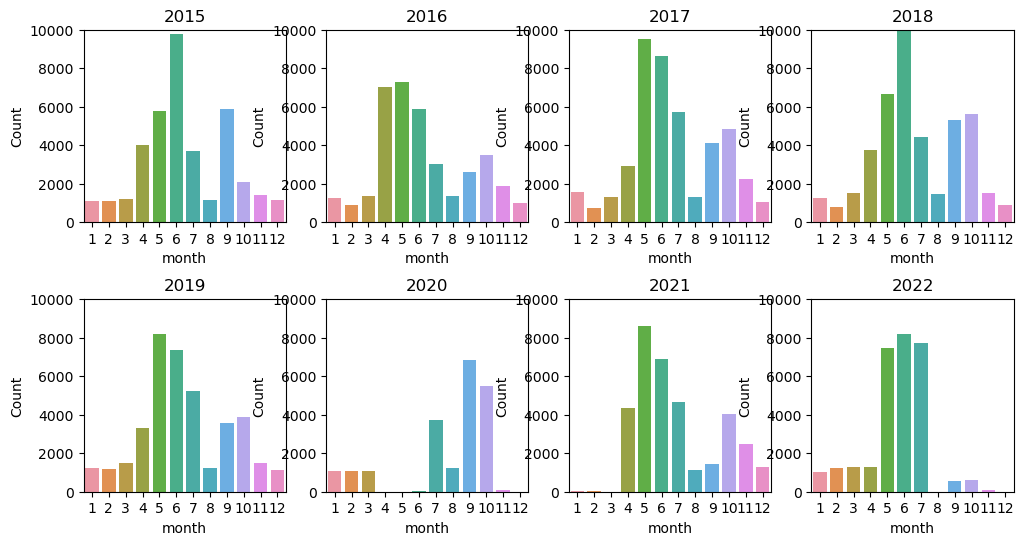

In [130]:
fig=plt.figure(figsize=(12,6))
fig.tight_layout()
years=[y for y in range(2015, 2023)]
for i in range(len(years)):
    df=monthly.loc[monthly.Datetime.dt.year==years[i]]
    axs=fig.add_subplot(241+i)
    axs.set_title(years[i])
    axs.set_ylim(0,10000)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    sns.barplot(data=df, x='month', y='Count', ax=axs)
    plt.subplots_adjust(hspace=0.4, wspace=0.2)

Show overall totals by month

<Axes: xlabel='month', ylabel='Count'>

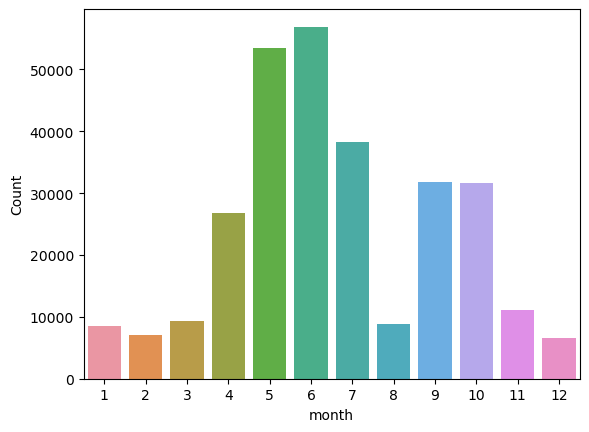

In [131]:
sns.barplot(x = monthly.month, y = monthly.Count, estimator = 'sum', errorbar = None)

With the help of stackoverflow, learn how to create table of months and years to see where the gaps are

In [132]:
monthly['year']=monthly.Datetime.dt.year
monthly=monthly.loc[(monthly['year'] <= 2022) & (monthly['year'] >=2015)] # as much data missing '14 and '22
monthly['month_']=monthly.Datetime.dt.month_name()
piv=monthly.pivot(columns='year', index='month_', values='Count')
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
piv = piv.reindex(new_order, axis=0) # https://stackoverflow.com/questions/48042915/sort-a-pandas-dataframe-series-by-month-name
piv.head(12)

year,2015,2016,2017,2018,2019,2020,2021,2022
month_,,,,,,,,
January,1104,1269,1588,1271,1214,1082,24,999
February,1079,907,758,808,1175,1067,16,1229
March,1196,1347,1311,1542,1514,1095,0,1269
April,4004,7047,2940,3758,3325,0,4359,1291
May,5783,7282,9539,6660,8186,0,8590,7478
June,9796,5886,8618,10057,7377,61,6895,8170
July,3718,3050,5721,4403,5236,3732,4663,7710
August,1142,1345,1293,1456,1241,1251,1146,0
September,5888,2583,4090,5300,3585,6862,1432,573


# Sampling

First, I created a dataframe with all the data in it then 'pickled' the file to make it easy to reuse and work with without having to scan the large number of CSV files which is very slow.  Comment these out once done so they don't re-run when running all cells. This file can be recreated by importing the pickle file.

In [45]:
def get_all():
    strat_files=os.listdir('strat_counts')
    strat=pd.concat([pd.read_csv('strat_counts/' + file) for file in strat_files if file[-1]== 'v'])
    cycleway_files=os.listdir('cycleway_counts')
    cycleway=pd.concat([pd.read_csv('cycleway_counts/' + file, 
                                    low_memory=False) for file in cycleway_files if file[-1]=='v'])
    central_files=os.listdir('central_counts')
    central=pd.concat([pd.read_csv('central_counts/' + file) for file in central_files if file[-1]=='v'])
    central['type']='central'
    strat['type']='strat'
    cycleway['type']='cycleway'
    df=pd.concat([strat, central, cycleway])
    return df

# all_years_raw=get_all()
# all_years=get_hourly(process_data(all_years_raw))
# all_years.to_pickle('all_years.pkl')
all_years=pd.read_pickle('all_years.pkl')

Now that all of the data is processed and in one place, the next step is to take a sensible sample - the dataset as it stands is too large to be practical, especially considering the need for making many API calls.  We therefore want to use a subset of the data that will provide sufficient analytical richness and robustness, but is manageable in scope. 

The sampling unit is a day's worth of counting at a given site - it is expected that cycling will vary by time of day (due to higher rates in rush hour) SOURCE and by the day within the year (due to more cycling in warmer months).  Using a day-site combination as the sampling unit helps to control for fluctuations during the day by definition, and will control for seasonal changes if the numbers in each month are consistent.  An alternative considered was to ensure an even mix of times of day and times of year, but separate these from the location. This may have made sampling easier, and ensured an exact even split of times of day and year, but could have been influenced by geographical variability (e.g. central loactions may be busier at a given time in given weather conditions than outer London).  

To keep the file sizes manageable, aim for around 1000 counts per month i.e. as shown in the charts above this is fairly common in colder months so makes sense as a starting point, however summer months have many more. Therefore we need a way of sampling to get around 1000 counts per month, preserving the days at a site.

This is best done as a series of linked functions.  The first groups a month's worth of data by site and day and shows how many counts there are for that day-site combination i.e. a complete day is in theory 16 hours but it seems that this is rare, however we can consider 8 or more would provide a good amount of data.  It then profiles the spread of 'day-site' counts within that month. i.e. ideally if there were e.g. 6000 total counts in a month, we would want that to mean 500 times that a site was visited for 12 hours. However in reality it's more of a mixed bag. This function therefore returns a table showing, for each value of k (the number of counts in a day at a site), how many day_site combinations match this in the given month. If we multiply the first 2 columns together we get the total number of (hourly) counts this corresponds to. The cumulative count then helps us decide on the value of k which is in the next function below.

This is best illustrated with a sample output

In [46]:
def get_profile(month_df):
    df=month_df.groupby(['UnqID', pd.Grouper(key='Datetime', freq='D')], 
                                       as_index=False).Count.count()
    df=df.rename(columns={"Count": "Counts_at_site_on_day"})
    profile=pd.DataFrame(df.Counts_at_site_on_day.value_counts())
    profile=profile.rename(columns={'count': 'no_of_daysites'}).sort_index(ascending=False)
    profile['counts']=profile.index * profile.no_of_daysites
    profile['cumu_count']=profile.counts.cumsum()
    return profile

may_2018=all_years.loc[(all_years.Datetime.dt.year==2018) & (
    all_years.Datetime.dt.month==5)]
test_profile=get_profile(may_2018)
test_profile

,no_of_daysites,counts,cumu_count
Counts_at_site_on_day,,,
16,3,48,48
14,2,28,76
13,6,78,154
12,26,312,466
11,6,66,532
10,11,110,642
9,23,207,849
8,488,3904,4753
7,29,203,4956


Once we have the profile, we can work out the value of k for that month. As above, we are sampling by day_site combination and want around 1,000 total (hourly) counts per month.  The cumulative count column helps decide on k - e.g. in the example above, any k above 8 would not get to 1,000 total counts, but with k=8 we have far more than enough records, therefore there is no need to go below this. We want to avoid low values of k if possible as this means much less than a day of data and more of a mix of times of day. That said, if the data supports a very high k (e.g. lots of day_dates with the full count of 16) this may not necessarily be optimal as it means fewer locations. Therefore I set a maximum k of 10 to get a decent spread of locations in all months. The process is therefore:
 - is the final cumulative count for the month is < 1000? If yes k=0 i.e. all data will be used
 - would k=10 provide 1,000 or more total counts? If yes, 10 is used
 - otherwise, we go row by row through the profile until we cross the cumulative count of 1,000, giving our corresponding k. 
 
 Again this is best illustrated with an example - it gives k=8 as is intuitive from the example profile above. 

In [47]:
def choose_k(profile):
    ten = profile.loc[profile.index==10]
    if profile.cumu_count.iloc[-1]<1000:
        k=0   # take all from months with few
    elif len(ten)>0 and ten.cumu_count.iloc[0]>1000:  
        k=10      
    else:
        i=0
        while profile.cumu_count.iloc[i]<1000:
            i+=1
        k=profile.index[i]
    return k

print(choose_k(test_profile))

8


Then, once k is chosen, we may need to take a sample of day_site combinations to get a total of 1000 counts in the month. If k = 0, we've already defined above that we want all data for that month as there will be < 1000.  For other months, including the example above, it might be that our chosen k gives far more than 1000, therefore we take a sample. For simplicity, we take 1000/k day_sites e.g. if k=8 we would sample 125 day_sites, however since some of these will have more than 8 counts we'd get mroe than 1000 counts for that month in total.

Once we have our sample of day_sites, we go back to the monthly data (i.e. before we grouped it by day) and do an inner join with our sample on the day_site combination i.e. all hourly records from the ssampled day_sites are retained. This is our monthly sample. 

Again, we illustrate with an example.

In [48]:
def get_sample(month_df):
    month_df['day_site']=month_df.UnqID + "_" + month_df.Datetime.dt.date.astype(str)
    profile=get_profile(month_df)
    k=choose_k(profile)
    by_day_and_site=month_df.groupby('day_site',as_index=False).Count.count()
    pop=by_day_and_site.loc[by_day_and_site.Count>=k]
    if k == 0:
        samp=pop
    else:
        n=int(1000/k)
        try: 
            samp=pop.sample(n=n, random_state=np.random.RandomState(), weights='Count')
        except:
            samp=pop
    sampled=pd.merge(left=month_df,right=samp, how='inner', on='day_site', suffixes=('', '_remove'))
    sampled.drop([i for i in sampled.columns if 'remove' in i],
                axis=1, inplace=True)
    return sampled

In [49]:
test_sample=get_sample(may_2018)
print(test_sample.head())
# Show how it has shrunk from our original monthly dataframe
print(f"\nThe sample contains {len(test_sample)} records vs {len(may_2018)} pre-sampling")

             Datetime     UnqID   timestamp   Latitude  Longitude  Count  \
0 2018-05-01 06:00:00  INNCY018  1538031600  51.467314  -0.117891   65.0   
1 2018-05-01 07:00:00  INNCY018  1538031600  51.467314  -0.117891  169.0   
2 2018-05-01 08:00:00  INNCY018  1538031600  51.467314  -0.117891  245.0   
3 2018-05-01 09:00:00  INNCY018  1538031600  51.467314  -0.117891  135.0   
4 2018-05-01 10:00:00  INNCY018  1538031600  51.467314  -0.117891   52.0   

              day_site  
0  INNCY018_2018-05-01  
1  INNCY018_2018-05-01  
2  INNCY018_2018-05-01  
3  INNCY018_2018-05-01  
4  INNCY018_2018-05-01  

The sample contains 1070 records vs 6660 pre-sampling


The above 3 functions therefore, for a given month's worth of data, work out how the sample should be selected and then draw it. To create the overall sample, we therefore need to apply these functions to each month of data in turn (by iterating through a list of the months in the dataset) and then join them together with pd.concat as below. 

In [50]:
def build_sample():
    full_df=all_years.loc[(all_years.Datetime.dt.year <= 2022) & (
        all_years.Datetime.dt.year >=2015)]
    full_df['month_year']=full_df.Datetime.dt.to_period('M')
    full_sample=pd.DataFrame(columns=full_df.columns)
    months=full_df.month_year.unique()
    i=1
    for month in months:
        month_df=full_df.loc[full_df.month_year==month]
        sampled=get_sample(month_df)
        full_sample=pd.concat([full_sample, sampled])
        i+=1
    full_sample=full_sample.drop(['month_year', 'day_site'], axis = 1)
    return full_sample

In [51]:
# x=build_sample()
# x.head()
# x.to_pickle('sample.pkl')
# x=pd.read_pickle('sample.pkl')
# x['py_datetime'] = x.Datetime.apply(lambda x: x.to_pydatetime())
# x['Timestamp'] = x.py_datetime.apply(lambda x: datetime.timestamp(x)).astype(int)
# x.drop(['py_datetime'], axis = 1)
# x.to_pickle('Sample_.pkl')

In [52]:
sample = pd.read_pickle('sample_.pkl')

In [53]:
sample.head()

,Datetime,UnqID,timestamp,Latitude,Longitude,Count,month_year,day_site,py_datetime,Timestamp
0,2015-01-05 06:00:00,CENCY147,1538031600,51.513063,-0.146372,17.0,2015-01,CENCY147_2015-01-05,2015-01-05 06:00:00,1420437600
1,2015-01-05 07:00:00,CENCY147,1538031600,51.513063,-0.146372,75.0,2015-01,CENCY147_2015-01-05,2015-01-05 07:00:00,1420441200
2,2015-01-05 08:00:00,CENCY147,1538031600,51.513063,-0.146372,90.0,2015-01,CENCY147_2015-01-05,2015-01-05 08:00:00,1420444800
3,2015-01-05 09:00:00,CENCY147,1538031600,51.513063,-0.146372,55.0,2015-01,CENCY147_2015-01-05,2015-01-05 09:00:00,1420448400
4,2015-01-05 10:00:00,CENCY147,1538031600,51.513063,-0.146372,26.0,2015-01,CENCY147_2015-01-05,2015-01-05 10:00:00,1420452000


Compare the monthly profile with the population

[Text(0.5, 0, 'Month'), Text(0, 0.5, 'Total number of\nrecords in sample')]

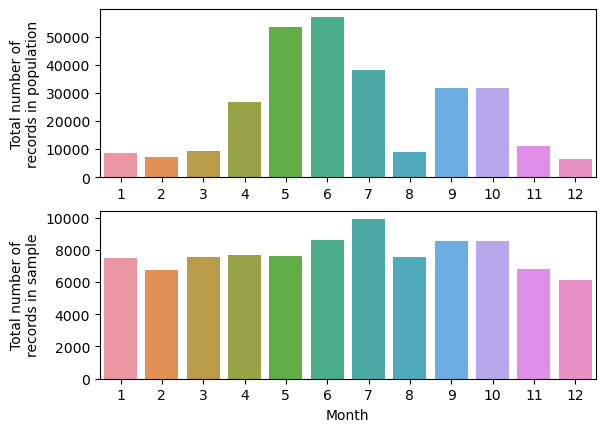

In [54]:
monthly_samp=pd.DataFrame(sample.groupby(pd.Grouper(key='Datetime', freq='M')).Count.count())
monthly_samp['month'] = monthly.Datetime.dt.month
fig, axes = plt.subplots(2,1)
sns.barplot(x = monthly.month, y = monthly.Count, estimator = 'sum', errorbar = None, ax = axes[0]).set(
    xlabel = None, ylabel = 'Total number of\nrecords in population')
sns.barplot(data = monthly_samp, x = 'month', y = 'Count', estimator = 'sum', errorbar = None, ax = axes[1]).set(
    xlabel = 'Month', ylabel = 'Total number of\nrecords in sample')


# Adding weather to the sample

The API has a (free) limit of 1000 calls per day. In part to keep the cost down, and also to help with processing speed, for now I create a function that takes a slice of 1000 records from the sample and adds the weather, then saves to disk so the call doesn't need to be rerun (it's historical data so won't change).  It will be straightforward to read and concatenate all the pkl files back together, this seems more straightforward and less prone to breakage than having some rows in the sample with weather populated and some not. The file names also make it easy to see where i'm up to.

In [55]:
def add_weather(thou):
    low=int(thou * 1000)
    high = low + 1000
    df=sample.iloc[low:high]
    df = weather_into_df(df)
    path = f"samples/{str(low)}to{str(high-1)}.pkl"
    df.to_pickle(path)
    print(f"{str(low)} to {str(high-1)} DONE")




# Adding darkness to sample and preparing for data analysis

Created a function to approximate darkness based on the timestamp.  If the timestamp is between sunrise and sunset we assume it's light, if it's either half an hour before sunrise or half an hour after sunset then it's 'gloomy', otherwise it's dark.  Can change these thresholds easily if needed.

In [56]:
def get_darkness (row):
    try:
        since_sunrise  = row.Timestamp - row.sunrise
        before_sunset = seconds = row.sunset - row.Timestamp
        if since_sunrise > 0 and before_sunset > 0:
            darkness = 'light'
        elif -1800 < since_sunrise <= 0 or -1800 < before_sunset <= 0:
            darkness = 'gloomy'
        elif since_sunrise < -1800 or before_sunset < -1800:
            darkness = 'dark'
        else:
            darkness = None
    except:
        darkness = None
    return darkness

For some reason the data processing to extract the main and detailed descriptions from the weather dictionary hasn't worked for a lot of rows but this is easy to fix with a couple of functions

In [57]:
def tidy_main(row):
    if pd.isna(row.main_descr): 
        try: 
            weather = row.weath[-1][0]
            row['main_descr'] = weather['main']
        except:
            row['main_descr'] = None
    else:
        row['main_descr'] = row.main_descr    
    return row['main_descr']

def tidy_detail(row):
    if pd.isna(row.detail_descr): 
        try: 
            weather = row.weath[-1][0]
            row['detail_descr'] = weather['description']
        except:
            row['detail_descr'] = None
    else:
        row['detail_descr'] = row.detail_descr    
    return row['detail_descr'] 

Create a function to prepare the data for analysis i.e. some of the columns won't be analysed, they're just used as inputs for the sampling functions and/ or the weather API. Now that we have the weather data we can also add the darkness variable and clean the descriptions using the functions above.  I've also extracted the rain information which was previously stored as a dictionary.

In [58]:
def prep_for_analysis(df):
    df['darkness'] = df.apply(lambda row: get_darkness(row), axis = 1)  
    df = df.drop(['index', 'timestamp', 'month_year', 'day_site', 'Latitude', 'Longitude', 
                 'py_datetime', 'Timestamp'], axis = 1)
    df['rain'] = df.rain.apply(lambda x: list(x.values())[0]if x else None)
    df['main_descr'] = df.apply(lambda row: tidy_main(row), axis = 1)
    df['detail_descr'] = df.apply(lambda row: tidy_detail(row), axis = 1)
    return df

Takes all the samples of 1000 and processes them

In [60]:
samples=os.listdir('samples')
data_untidied=pd.concat([pd.read_pickle('samples/' + file) for file in samples if file[-1]== 'l'], ignore_index=True)
data = prep_for_analysis(data_untidied)

# Exploratory data analysis and feature engineering

Now that we have some data we can look into further lines of enquiry.  View the spread of some weather variables. Visibility seems to be causing issues with seaborn so we will look at these separately.

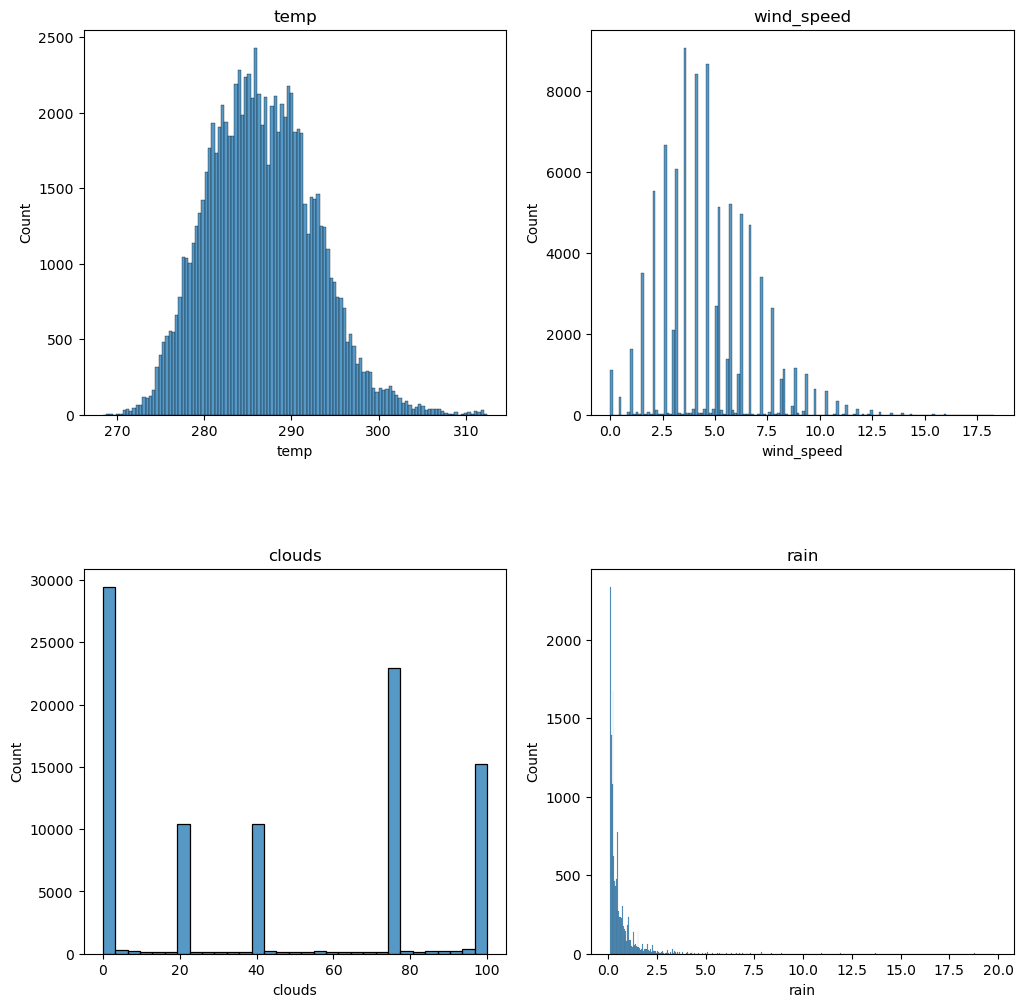

In [61]:
cont=['temp', 'wind_speed', 'clouds', 'rain']
fig=plt.figure(figsize=(12,12))
for i in range(4):
    axs=fig.add_subplot(221+i)
    axs.set_title(cont[i])
    sns.histplot(data=data, x=cont[i], ax=axs)
    plt.subplots_adjust(hspace=0.4, wspace=0.2)




The temperature is clearly in Kelvin. We convert to centigrade, and given the simplicity of the conversion and zero analytical risk of the conversion we do this in place.

In [62]:
data['temp'] = data.temp - 273.15

Clouds looks to be discretely binned but rather than being evely spaced between 0 and 100 the others fall at 20, 40 and 75 (when quintiles of 20,40,60 and 80 would be expected.  

To understand better we quantify how many points aren't one of these 5 values

In [63]:
bin_cloud = len(data[data.clouds.isin([0,20,40,75,100])])
other_cloud = len(data[~data.clouds.isin([0,20,40,75,100])])        
no_cloud = data.clouds.isnull().sum()
other_cloud = other_cloud - no_cloud
print(f"Of {bin_cloud + other_cloud} records for which cloud data is available, {bin_cloud:,} are 0,20,40,75 or 100, compared with {other_cloud:,}, or {other_cloud/(bin_cloud + other_cloud):.1%} that are not")

Of 92938 records for which cloud data is available, 86,800 are 0,20,40,75 or 100, compared with 6,138, or 6.6% that are not


Since the data can't really be treated as continous with such large bins, we assign the other points to the nearest value.

<Axes: xlabel='tidied_clouds', ylabel='Count'>

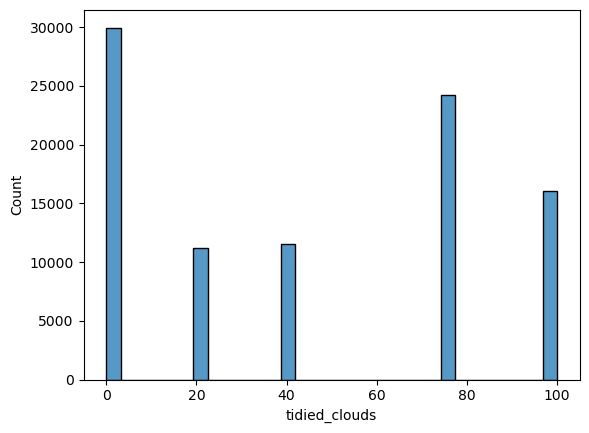

In [64]:
def tidy_cloud(x):
    if x in [0,20,40,75,100]:
        cloud = x
    elif x < 10:
        cloud = 0
    elif x < 30:
        cloud = 20
    elif x < 57.5:
        cloud = 40
    elif x < 87.5:
        cloud = 75
    else:
        cloud = 100
    return cloud

data['tidied_clouds'] = data.clouds.apply(lambda x: tidy_cloud(x))
sns.histplot(data.tidied_clouds)

Rain also looks to be heavily skewed. As suggested in literature we transform this, and to centre it. Literature also suggests wind speed works well with sqr rt transformation


<Axes: xlabel='wind_speed', ylabel='Count'>

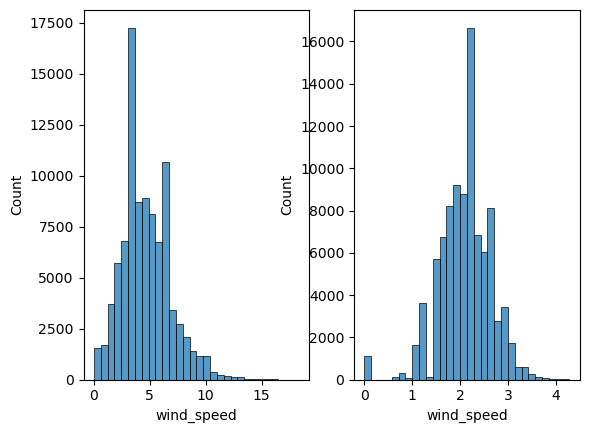

In [65]:
fig, axs = plt.subplots(1,2) 
sns.histplot(data.wind_speed, bins=30, ax = axs[0])
sns.histplot(np.sqrt(data.wind_speed), bins = 30, ax = axs[1])


This looks more centred. We try a few options for rain - cube root as suggested in the paper as well as square root and log which they also mention but don't use.  All look better however we use the cube root for modelling as per literature. 

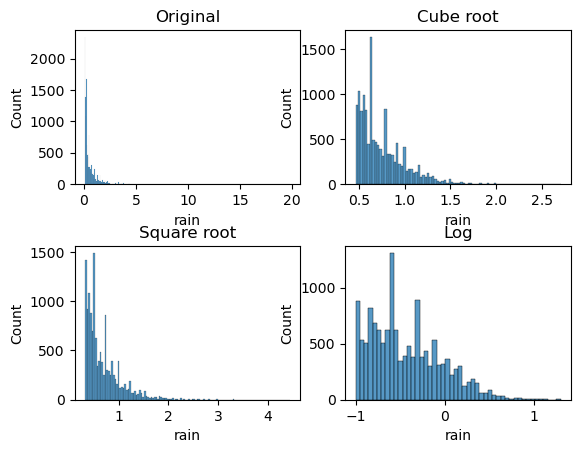

In [66]:
def explore_rain(data):
    fig, axs = plt.subplots(2,2)
    sns.histplot(data.rain, ax = axs[0][0]).set_title("Original")
    sns.histplot(data.rain ** (1/3), ax = axs[0][1]).set_title("Cube root")
    sns.histplot(data.rain ** 0.5, ax = axs[1][0]).set_title("Square root")    
    sns.histplot(np.log10(data.rain), ax = axs[1][1]).set_title("Log")
    plt.subplots_adjust(hspace=0.4, wspace=0.2)

explore_rain(data)


Examining visibility, it is clearly binned to the nearest 1000 for values of 5000 and above, but as with clouds, there are others in the mix so we investigate how many

In [67]:
print(data.visibility.value_counts())

visibility
9999.0     46426
10000.0    35186
9000.0      1309
8000.0      1298
6000.0      1221
           ...  
1500.0         7
600.0          4
1300.0         4
350.0          2
50.0           2
Name: count, Length: 63, dtype: int64


The bulk of values are 9999 but as this is visibility in metres it is unlikely there is any practical distinction between 9999 and 10000 (the maximum, meaning many of the 9999 may also be the maximum) therefore these are combined, then the value counts examined in full

In [68]:
data['visibility_tidied'] = np.where(data.visibility == 9999, 10000, data.visibility)
vvc = data.visibility_tidied.value_counts().sort_index()
pd.concat([vvc, vvc.cumsum(), 100 * vvc.cumsum()/(len(data) - data.visibility.isnull().sum())], axis = 1)

,count,count,count
visibility_tidied,,,
50.0,2,2,0.002222
100.0,29,31,0.034440
150.0,16,47,0.052216
200.0,18,65,0.072213
250.0,12,77,0.085545
...,...,...,...
6000.0,1221,4609,5.120485
7000.0,1183,5792,6.434769
8000.0,1298,7090,7.876815


So they are in bins of 50 up to 700 (or possibly 1000 if there was data), then 100 up to 5000 then 1000.  This grouping may have made sense to distinguish between lots of rows with low visibility, however only around 1% have a visibility of 3000 or below, therefore we round to the nearest 1000. The function can therefore be much simpler than it was for clouds. 

In [69]:
data['visibility_tidied'] = data.visibility_tidied.apply(lambda x: round(x, -3))
data.visibility_tidied.value_counts()

visibility_tidied
10000.0    81612
9000.0      1309
8000.0      1298
5000.0      1278
6000.0      1221
7000.0      1183
4000.0      1018
3000.0       428
2000.0       346
0.0          161
1000.0       157
Name: count, dtype: int64

Now we can investigate the counts of the qualitative descriptions of weather, starting with the main description.

<Axes: xlabel='count', ylabel='main_descr'>

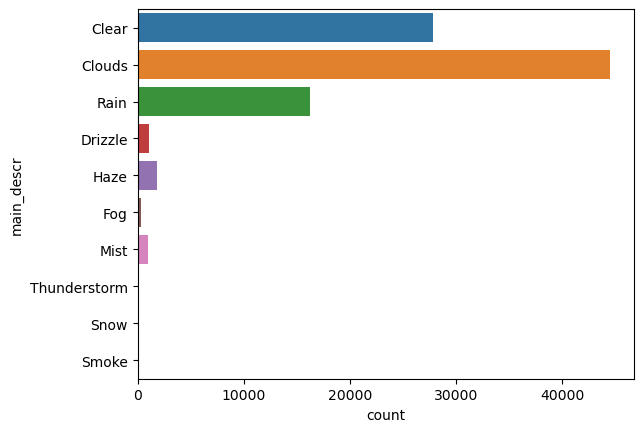

In [70]:
plt.figure()
sns.countplot(data = data, y= 'main_descr')

Investigating the exact numbers in the less common categories shows some are very small. Therefore we combine mist and fog as the hazard they present to cyclists is similar, and put snow and thunderstorms in with rain

In [71]:
data.main_descr.value_counts()

main_descr
Clouds          44500
Clear           27869
Rain            16242
Haze             1871
Drizzle          1044
Mist              953
Fog               303
Thunderstorm       79
Snow               59
Smoke              18
Name: count, dtype: int64

In [72]:
data['main_descr_adj'] = np.where(data.main_descr.isin(['Snow', 'Thunderstorm', 'Rain']), 'Rain/ storm/ snow', 
                                  (np.where(data.main_descr.isin(["Mist", "Fog"]), 'Mist or fog', data.main_descr)))

Next let's look at the detailed descriptions.

<Axes: xlabel='count', ylabel='detail_descr'>

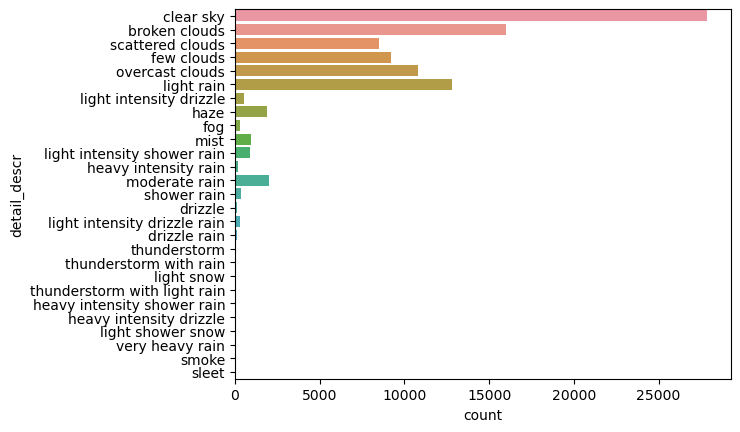

In [73]:
plt.figure()
sns.countplot(data = data, y = 'detail_descr')

Suggests that the detailed descriptions are unlikely to be useful since many data points are different types of cloud which is unlikely to be of great analytical value (e.g the distinction between broken clouds and few clouds is unlikely to impact cycling rates but we confirm with further analysis).  However investigating the different intensities of rain may be useful.  If the main description is rain, we investigate the detailed one, but if it isn't, we ignore

In [74]:
data['combined_descr'] = np.where(data.main_descr_adj == "Rain/ storm/ snow", data.detail_descr, data.main_descr)
data.combined_descr.value_counts()

combined_descr
Clouds                          44500
Clear                           27869
light rain                      12835
moderate rain                    1993
Haze                             1871
Drizzle                          1044
Mist                              953
light intensity shower rain       889
shower rain                       339
Fog                               303
heavy intensity rain              168
light snow                         52
thunderstorm                       45
thunderstorm with rain             23
Smoke                              18
heavy intensity shower rain        17
thunderstorm with light rain       11
light shower snow                   5
sleet                               2
very heavy rain                     1
Name: count, dtype: int64

Again some of these categories are very sparse, however being able to distinguish between light rain and moderate/ heavy rain may be useful. Therefore categories are combined as below

In [75]:
data['combined_descr'] = np.where(data.combined_descr.isin(['light intensity shower rain', 'light rain', 'Drizzle', 'sleet']), 'light rain/ drizzle', 
                                  (np.where(data.combined_descr.isin(['moderate rain', 'shower rain' , 'heavy intensity rain', 'heavy intensity shower rain',
                                     'light snow', 'thunderstorm', 'thunderstorm with rain', 'light shower snow', 'thunderstorm with light rain']), 
                                            'mod+heavy rain/ snow/ storm', data.combined_descr)))
data.combined_descr.value_counts()

combined_descr
Clouds                         44500
Clear                          27869
light rain/ drizzle            14770
mod+heavy rain/ snow/ storm     2653
Haze                            1871
Mist                             953
Fog                              303
Smoke                             18
very heavy rain                    1
Name: count, dtype: int64

There are many entries for which the rain is null. We should check how this relates to the qualitative description of rain i.e. if rainy time slots have a value for rain, it might be assumed that those with nothing for rain reflects zero rain at that time, whereas if it is common to have a qualitative description for rain but no value then data is incomplete.

In [76]:
mod_rain = data.loc[data.combined_descr == 'mod+heavy rain/ snow/ storm']
light_rain = data.loc[data.combined_descr == 'light rain/ drizzle']
no_rain = data.loc[~data.combined_descr.isin(['light rain/ drizzle', 'mod+heavy rain/ snow/ storm'])]
for df in [mod_rain, light_rain, no_rain]:
    print(df.rain.isnull().sum()/len(df))

0.10893328307576329
0.212863913337847
0.9994972015295659


Almost all of those without a description related to rain have null in the rain column, suggesting it could indicate 0 rain, however, it still leaves many missing even on days of heavy rain. To allow it to be used in analysis we assume null is zero if the description indicates there wasn't rain, and use the average for that day if avaialble, otherwise the month

In [77]:
def get_daily_mean(row):
    day_df = data.loc[data.Datetime.dt.date == row.Datetime.date()]
    if len(day_df[day_df.rain>0]) > 0:
        mean_rain = day_df.rain.mean()
    else:
        month_df = data.loc[data.Datetime.dt.month == row.Datetime.month]
        mean_rain = month_df.rain.mean()
    return mean_rain

data['rain_adj'] = data.apply(lambda row: 0 if row.combined_descr not in ['light rain/ drizzle', 'mod+heavy rain/ snow/ storm'] else get_daily_mean(row), axis =1)


Next plotting some bivariate histograms of the continuous variables against the cycling counts to understand variaton (scatterplots would have significant occlusion, particularly for rain which is often zero)

In [78]:
data.sort_values(by = ['Count'], ascending = False).head(10)

,Datetime,UnqID,Count,weath,sunrise,sunset,temp,wind_speed,wind_deg,visibility,clouds,rain,main_descr,detail_descr,darkness,tidied_clouds,visibility_tidied,main_descr_adj,combined_descr,rain_adj
30470,2022-06-15 18:00:00,CENCY061,8374.0,"[1655264568, 1655324357, 300.35, 6.69, 80, 100...",1.655265e+09,1.655324e+09,27.20,6.69,80.0,10000.0,34.0,NaN,Clouds,scattered clouds,light,40.0,10000.0,Clouds,Clouds,0.0
30469,2022-06-15 17:00:00,CENCY061,7454.0,"[1655264568, 1655324357, 300.48, 7.72, 100, 10...",1.655265e+09,1.655324e+09,27.33,7.72,100.0,10000.0,59.0,NaN,Clouds,broken clouds,light,75.0,10000.0,Clouds,Clouds,0.0
13282,2022-05-18 08:00:00,CENCY039,6862.0,"[1652846668, 1652903358, 287.81, 3.6, 250, 100...",1.652847e+09,1.652903e+09,14.66,3.60,250.0,10000.0,93.0,NaN,Clouds,overcast clouds,light,100.0,10000.0,Clouds,Clouds,0.0
13291,2022-05-18 17:00:00,CENCY039,6148.0,"[1652846668, 1652903358, 296.06, 4.12, 0, 1000...",1.652847e+09,1.652903e+09,22.91,4.12,0.0,10000.0,100.0,NaN,Clouds,overcast clouds,light,100.0,10000.0,Clouds,Clouds,0.0
13234,2022-05-17 08:00:00,CENCY126,5832.0,"[1652760352, 1652816871, 289.19, 2.06, 100, 10...",1.652760e+09,1.652817e+09,16.04,2.06,100.0,10000.0,66.0,NaN,Clouds,broken clouds,light,75.0,10000.0,Clouds,Clouds,0.0
30468,2022-06-15 16:00:00,CENCY061,5817.0,"[1655264568, 1655324357, 300.64, 6.17, 90, 100...",1.655265e+09,1.655324e+09,27.49,6.17,90.0,10000.0,31.0,NaN,Clouds,scattered clouds,light,40.0,10000.0,Clouds,Clouds,0.0
30471,2022-06-15 19:00:00,CENCY061,5717.0,"[1655264568, 1655324357, 298.19, 6.69, 80, 100...",1.655265e+09,1.655324e+09,25.04,6.69,80.0,10000.0,9.0,NaN,Clear,clear sky,light,0.0,10000.0,Clear,Clear,0.0
30465,2022-06-15 13:00:00,CENCY061,5382.0,"[1655264568, 1655324357, 299.13, 2.57, 90, 100...",1.655265e+09,1.655324e+09,25.98,2.57,90.0,10000.0,53.0,NaN,Clouds,broken clouds,light,40.0,10000.0,Clouds,Clouds,0.0
30467,2022-06-15 15:00:00,CENCY061,5347.0,"[1655264568, 1655324357, 300.48, 1.85, 197, No...",1.655265e+09,1.655324e+09,27.33,1.85,197.0,NaN,33.0,NaN,Clouds,scattered clouds,light,40.0,NaN,Clouds,Clouds,0.0
13243,2022-05-17 17:00:00,CENCY126,5325.0,"[1652760352, 1652816871, 298.33, 5.14, 150, 10...",1.652760e+09,1.652817e+09,25.18,5.14,150.0,10000.0,30.0,NaN,Clouds,scattered clouds,light,40.0,10000.0,Clouds,Clouds,0.0


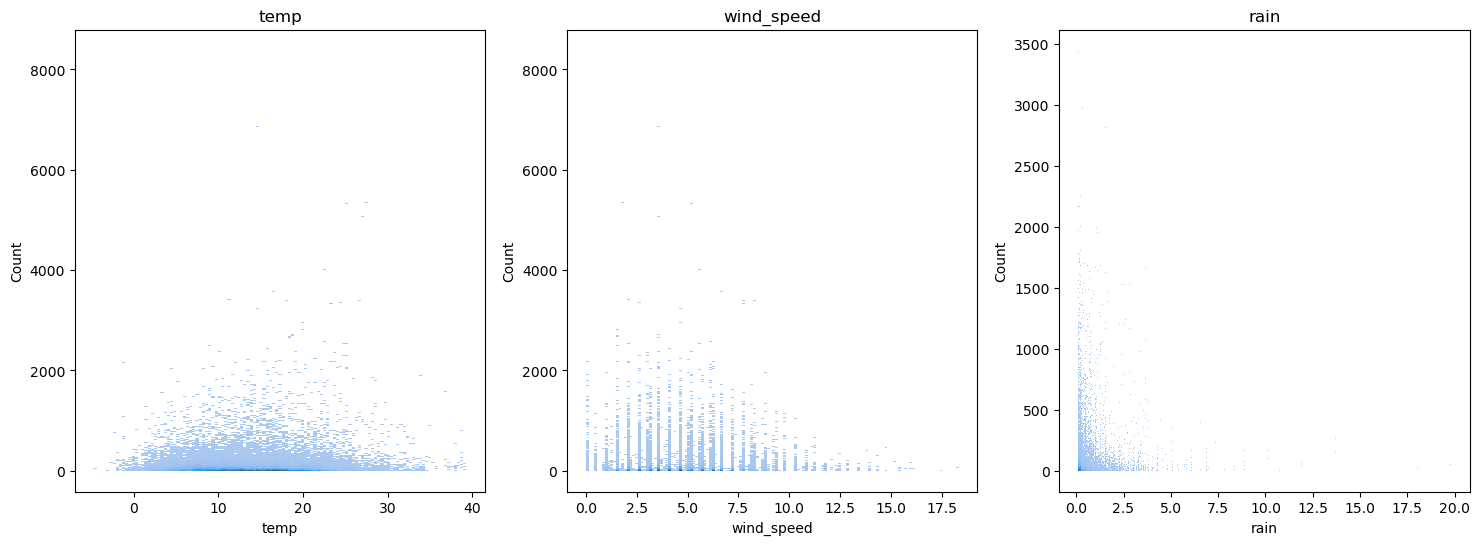

In [79]:
cont=['temp', 'wind_speed', 'rain']

fig=plt.figure(figsize = (18,6))
for i in range(len(cont)):
    axs=fig.add_subplot(131+i)
    axs.set_title(cont[i])
    sns.histplot(data=data, x=cont[i], y='Count', ax=axs)
    plt.subplots_adjust(hspace=0.4, wspace=0.2)

It can be difficult to see due to some very high counts.  However, investigating the site IDs shows the top 3 are Blackfriars Bridge, Kennington Park Road and London Bridge, i.e. all major routes into London and with cycle lanes, therefore these counts are plausible. REFLECTION MAY HAVE BEEN BETTER TO FOCUS ON SOME OF THESE OVER TIME??  We therefore cap the count at 1000 to see the bulk of the data more easily

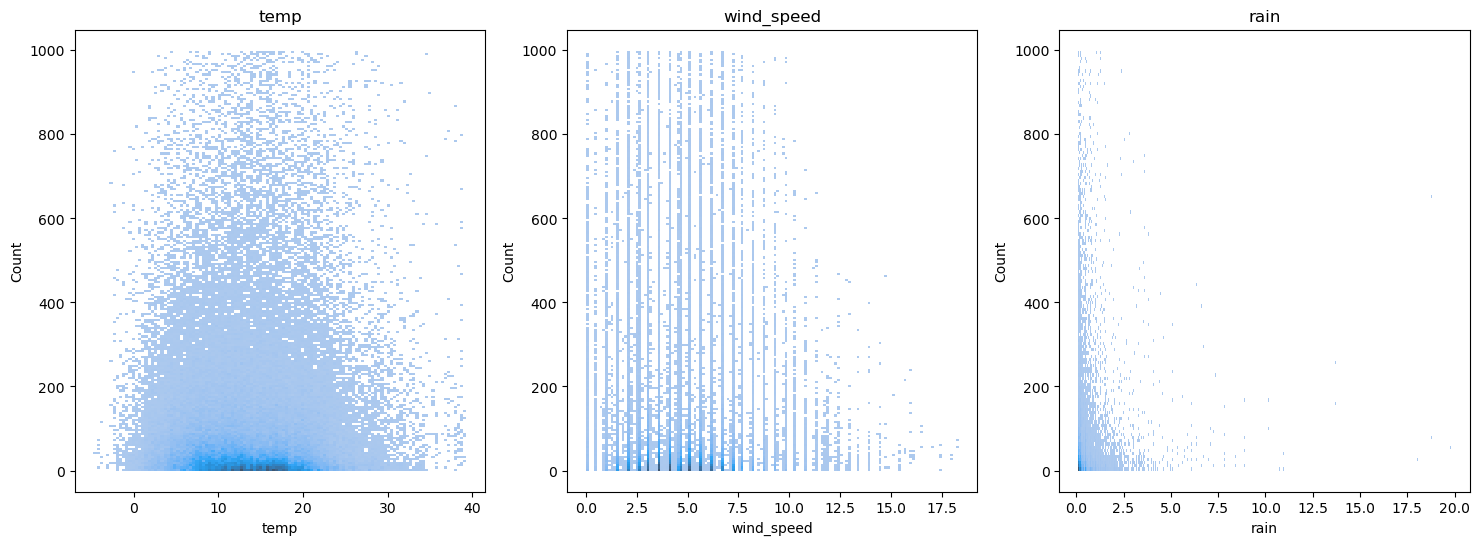

In [80]:
fig=plt.figure(figsize = (18,6))
for i in range(len(cont)):
    axs=fig.add_subplot(131+i)
    axs.set_title(cont[i])
    sns.histplot(data=data[data.Count < 1000], x=cont[i], y='Count', ax=axs)
    plt.subplots_adjust(hspace=0.4, wspace=0.2)

And for categorical variables look at a boxenplot 

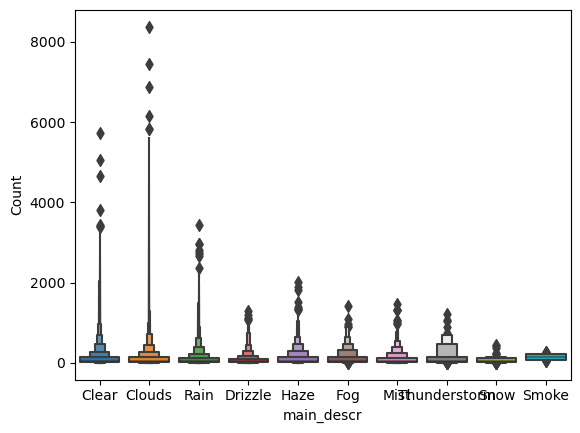

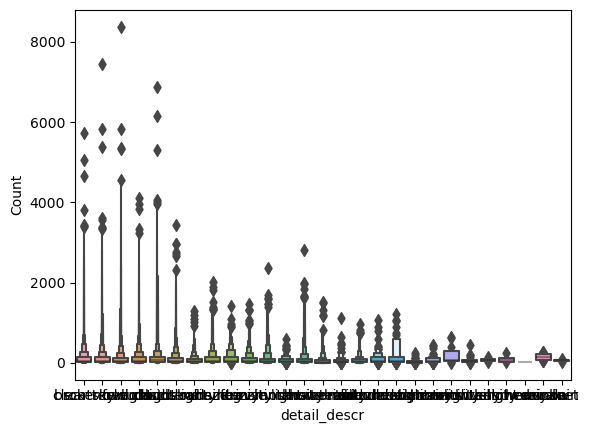

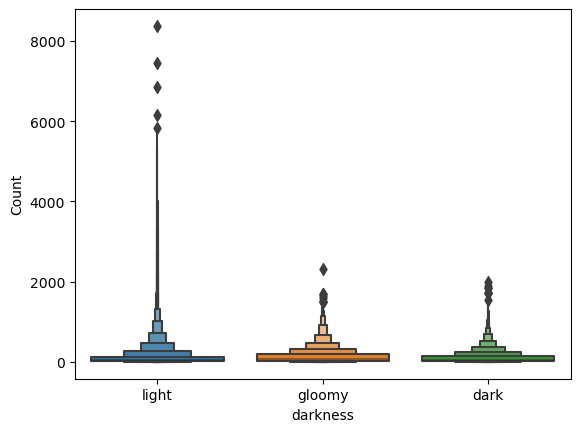

In [81]:
discr = ['main_descr', 'detail_descr', 'darkness']
for var in discr:
        plt.figure() 
        sns.boxenplot(data = data, x = var, y = 'Count')

With so many counts at zero it's not easy to see but we can compare means

In [82]:
print(data.groupby('main_descr').Count.mean())
print(data.groupby(['main_descr', 'darkness']).Count.mean())

main_descr
Clear           134.360149
Clouds          131.934989
Drizzle          86.553640
Fog             132.402640
Haze            131.027258
Mist            112.253935
Rain            110.485593
Smoke           145.888889
Snow             79.745763
Thunderstorm    155.202532
Name: Count, dtype: float64
main_descr    darkness
Clear         dark        112.375139
              gloomy      137.981621
              light       139.734794
Clouds        dark        116.741509
              gloomy      156.663331
              light       133.638250
Drizzle       dark         79.606635
              gloomy      143.706897
              light        84.167742
Fog           dark         63.194444
              gloomy      112.880000
              light       158.961165
Haze          dark        115.982301
              gloomy      139.142857
              light       135.573051
Mist          dark         75.461988
              gloomy      132.890110
              light       118.641100
Ra

Suggests may not be the relationship we expect given rainy is similar to clear, and higher than drizzle, and more appear to cycle in gloomy conditions than in the day. However, I expect much cycling happens in rush hour which will be close to or in darkness. To get an indication of this, we plot the count by hour of the day.

[Text(0.5, 0, 'Hour of day'), Text(0, 0.5, 'Average cycle count per site')]

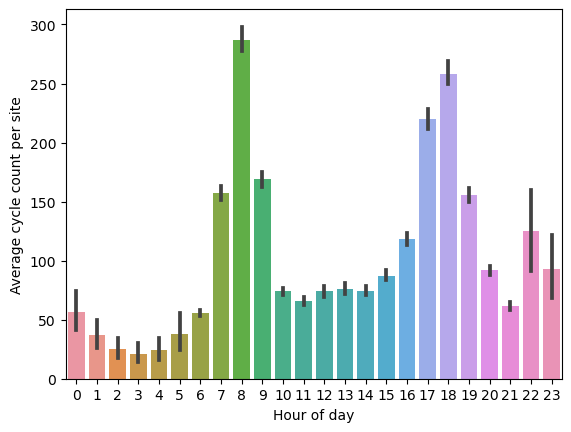

In [83]:
data['hour'] = data.Datetime.dt.hour
sns.barplot(data = data, x = 'hour', y = 'Count').set(xlabel = 'Hour of day', ylabel = 'Average cycle count per site')

In [84]:
crossed = pd.crosstab(index = data.hour, columns = data.main_descr, values = data.Count, aggfunc = 'mean')
# now we're getting somewhere
# focus on 8-9 and 1700 - 1900
morn_rush =data.loc[data.hour == 8]
eve_rush = data.loc[data.hour.isin([17,18])]
print(morn_rush.groupby('main_descr').Count.mean())
print(eve_rush.groupby('main_descr').Count.mean())


# so maybe test these proportions and construct some separate regression models for morning rush, eveniing rush and off peak.
#NEW HYP - evneish rush less affectd as may have already ridden to work?

main_descr
Clear      317.951877
Clouds     295.266509
Drizzle    188.969388
Fog        218.419753
Haze       263.802239
Mist       244.842466
Rain       225.016787
Smoke      110.000000
Snow        88.333333
Name: Count, dtype: float64
main_descr
Clear           242.788686
Clouds          246.243851
Drizzle         124.986111
Fog              51.000000
Haze            204.160000
Mist            122.562500
Rain            222.933525
Smoke           159.200000
Snow             65.000000
Thunderstorm    313.958333
Name: Count, dtype: float64


Look at the combined description- shows a difference between clear and clouds and rain, compare with scipy

In [85]:
morn_rush.groupby('combined_descr').Count.mean()

combined_descr
Clear                          317.951877
Clouds                         295.266509
Fog                            218.419753
Haze                           263.802239
Mist                           244.842466
Smoke                          110.000000
light rain/ drizzle            228.130597
mod+heavy rain/ snow/ storm    175.809160
Name: Count, dtype: float64

# Statistical analyses

Before building models, see if average cycling levels are higher in rainy weather using the qualitative descriptions, and look at correlations between cycling counts and continuous variables

In [87]:
clear_cloudy = morn_rush.loc[morn_rush.combined_descr.isin(['Clear', 'Clouds'])].Count
wet = morn_rush.loc[morn_rush.combined_descr.isin(['light rain/ drizzle', 'mod+heavy rain/ snow/ storm'])].Count
sig_test = ttest_ind(clear_cloudy, wet)
print(clear_cloudy.mean(), wet.mean())
print(sig_test)
corr_df = morn_rush[['wind_speed', 'rain_adj', 'tidied_clouds', 'temp', 'visibility_tidied', 'Count']].dropna()
corr_df['rain_cr'] = corr_df.rain_adj ** (1/3)
corrs = {}
for col in corr_df.columns[:-1]:
    corrs[col] = pearsonr(corr_df[col], corr_df.Count)
for item in corrs.items():
    print(item)

304.9391206313416 220.8
TtestResult(statistic=5.534518460209871, pvalue=3.2688660543504004e-08, df=5368.0)
('wind_speed', PearsonRResult(statistic=-0.02257150414297031, pvalue=0.09155059065106094))
('rain_adj', PearsonRResult(statistic=-0.07160208853938338, pvalue=8.385730982664271e-08))
('tidied_clouds', PearsonRResult(statistic=-0.046865388902911816, pvalue=0.000456983979034584))
('temp', PearsonRResult(statistic=0.009062276551416854, pvalue=0.49818095042281724))
('visibility_tidied', PearsonRResult(statistic=0.01742359053040563, pvalue=0.1927836410256056))
('Count', PearsonRResult(statistic=1.0, pvalue=0.0))


This difference is significant although correletaions find nothing , confirming what is expected from graphs

# Regression modelling

Start with the morning rush hour as there was more evidence of a relationship. Print the columns to remind us of the predictors

In [134]:
morn_rush.columns

Index(['Datetime', 'UnqID', 'Count', 'weath', 'sunrise', 'sunset', 'temp',
       'wind_speed', 'wind_deg', 'visibility', 'clouds', 'rain', 'main_descr',
       'detail_descr', 'darkness', 'tidied_clouds', 'visibility_tidied',
       'main_descr_adj', 'combined_descr', 'rain_adj', 'hour'],
      dtype='object')

Build a function that standardises predictors as recommended in a paper about feature engineering in weather (see report) and then set up a means of easily building a range of regression models without having to keep adding extra code - we can just confirm the data frame (i.e. could be morn_rush, or evening, or all), the predictors, the model and the categorical predictors so dummies can be added.

In [90]:
lasso = Lasso()
ridge = Ridge()
lin_reg = LinearRegression()

def standardise(df, predictors):
    if 'wind_speed' in predictors:
        df['wind_speeed'] = np.sqrt(df.wind_speed)
        wind_scale = StandardScaler()
        df['wind_speed'] = wind_scale.fit_transform(np.reshape(df.wind_speed, (-1,1)))
    if 'temp' in predictors:
        temp_scale = StandardScaler()
        df['temp'] = temp_scale.fit_transform(np.reshape(df.temp, (-1,1)))
    if 'rain_adj' in predictors:
        df['rain_adj'] = df.rain_adj ** (1/3)
        rain_scale = MinMaxScaler()
        df['rain_adj'] = rain_scale.fit_transform(np.reshape(df.rain_adj, (-1,1)))
    if 'tidied_clouds' in predictors:
        cloud_scale = MinMaxScaler()
        df['tidied_clouds'] = cloud_scale.fit_transform(np.reshape(df.tidied_clouds, (-1,1)))
    if 'visibility_tidied' in predictors:
        vis_scale = MinMaxScaler()
        df['visibility_tidied'] = vis_scale.fit_transform(np.reshape(df.visibility_tidied, (-1,1)))
    return df

def do_regression(df, predictors, model, cat_vars = None):
    df = standardise(df, predictors) 
    df = pd.get_dummies(df, columns = cat_vars, dtype = int)
    for var in cat_vars:
        cat_labels = [col for col in df.columns if var in col]
        predictors += predictors + cat_labels
    predictors = list(set(predictors).difference(set(cat_vars)))
    nulls = [] 
    for predictor in predictors:
        if df[predictor].isnull().sum() > 0.01 * len(df):
            nulls.append(predictor)
    if len(nulls) > 0:
        print(f"Too many null values in {nulls}, remove/ fill them or choose different predictors")
    else:
        clean = df[predictors + ['Count']].dropna()
        X = clean[predictors]
        y = clean.Count
        score = cross_val_score(model, X, y, scoring = 'r2')
        return score
      





For analysis, it actually may be making things worse having the location which is such a big determinant, perhaps this should be removed.  Can see below an example output, although lots were tried - the cross validated r2 is low in all 5 runs.

In [91]:
do_regression(morn_rush, ['rain_adj', 'combined_descr'], lasso, ['combined_descr'])


array([ 0.00501868,  0.00998742,  0.00642436, -0.01386371,  0.00739659])

# Clustering

Experiment with clustering in case we can identify features associated with rain even if regression was inconclusive. The clustering algorithms in sklearn need continuous data so select those columns plus datetime and id as index so we can link back to original data if needed.

In [139]:
to_cluster = data[['UnqID', 'Datetime', 'temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied','Count', 'hour']]
to_cluster = to_cluster.set_index(['UnqID', 'Datetime'])

Start by removing visibility and dropping na from other rows, we can try to improve things by better use of visibility afterwards.  Try a range of values of k and get scores.

In [143]:
to_cluster = to_cluster.dropna()
norm = Normalizer()
to_cluster[to_cluster.columns] = norm.fit_transform(to_cluster)
scores = {}
for k in (list(range(2,11)) + list(range(12,22,2)) + list(range(25, 101, 5))):
    k_means = KMeans(n_clusters = k, n_init = 10)
    clusters = k_means.fit(to_cluster)
    labels = clusters.labels_
    scores[k] = silhouette_score(to_cluster, labels, metric='euclidean', sample_size = 10000)
scores




{2: 0.9845966647064542,
 3: 0.819708104823368,
 4: 0.8229081795397624,
 5: 0.7496852126764463,
 6: 0.6542509789292961,
 7: 0.6487109069567198,
 8: 0.594519936841162,
 9: 0.5403701906070855,
 10: 0.5261623830063646,
 12: 0.49053504456017083,
 14: 0.4213122230374589,
 16: 0.4364176215064784,
 18: 0.44193044886034877,
 20: 0.43402326039829847,
 25: 0.4206129589321494,
 30: 0.43724762559922603,
 35: 0.41877064712578077,
 40: 0.4299838484822279,
 45: 0.40046869732349943,
 50: 0.375911004150695,
 55: 0.387871263724717,
 60: 0.3634467756642476,
 65: 0.35124170849041875,
 70: 0.3683949837752425,
 75: 0.3631831178008269,
 80: 0.3597187000479284,
 85: 0.3619623043827338,
 90: 0.35347151077414773,
 95: 0.36655518119332675,
 100: 0.35432536632742895}

Helped by sklearn example we try mean-shift https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html#sphx-glr-auto-examples-cluster-plot-mean-shift-py

In [144]:
bandwidth = estimate_bandwidth(to_cluster, n_samples = 10000, random_state = 142)
ms = MeanShift(bandwidth = bandwidth, bin_seeding = True)
ms.fit(to_cluster)

ms_labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 100


See how many are in each cluster - we can see even though there are 100 clusters, over 90% are in cluster 0 and 99% are in the top 3 clusters.

In [159]:
to_cluster['ms_clusters'] = ms_labels
pd.DataFrame({'count':to_cluster.ms_clusters.value_counts(),
                      'cumu percent':100*to_cluster.ms_clusters.value_counts().cumsum()/len(to_cluster)})


,count,cumu percent
ms_clusters,,
0,84945,94.371799
8,2258,96.880381
3,1745,98.819033
22,269,99.117886
1,127,99.258979
...,...,...
153,1,99.995556
187,1,99.996667
167,1,99.997778


Look at the profiles of the 3 most populous ones to see if they are informative - not clear with normalized data, would have been better to append clusters to pre-normalized data. However can see that count is much higher in cluster 8 and 3 than 0.

In [164]:
for clus in [0,8,3]:
    df = to_cluster.loc[to_cluster.ms_clusters == clus]
    print(clus, "\n", df.mean(), "\n")

0 
 temp                 0.001412
rain_adj             0.000013
wind_speed           0.000496
tidied_clouds        0.004714
visibility_tidied    0.999876
Count                0.009021
hour                 0.001421
ms_clusters          0.000000
dtype: float64 

8 
 temp                 0.001592
rain_adj             0.000017
wind_speed           0.000518
tidied_clouds        0.007254
visibility_tidied    0.997782
Count                0.065018
hour                 0.001594
ms_clusters          8.000000
dtype: float64 

3 
 temp                 0.001626
rain_adj             0.000014
wind_speed           0.000506
tidied_clouds        0.005870
visibility_tidied    0.994423
Count                0.103613
hour                 0.001538
ms_clusters          3.000000
dtype: float64 



Checking where these counts are shows it is busy central London locations which may explain why they have high counts but similar weather to cluster 0

In [170]:
site_check = pd.merge(to_cluster.loc[to_cluster.ms_clusters == 8].reset_index(level = ['UnqID']).UnqID.value_counts(), 
                      locations[['Site ID', 'Location description']], left_index = True, right_on = 'Site ID')
site_check

,count,Site ID,Location description
31,40,CENCY032,Borough High Street
51,36,CENCY052,Theobald's Road
86,34,CENCY088,Clerkenwell Road (east)
16,34,CENCY017,Waterloo Bridge
14,32,CENCY015,Millbank (north of Great Peter Street)
...,...,...,...
2283,1,SC14,London Bridge jw Cannon Street / Tooley Street
61,1,CENCY062,Charing Cross Road
465,1,CSHCY008,Wordworth Road
1954,1,QWPCY048,Southwark Bridge Road (south)


Experiment with first doing PCA for variables other than count - this would allow plotting in 3D space if clusters look useful

In [172]:
pca = PCA (n_components = 2)
X = to_cluster.drop(['Count'], axis = 1)
X_new = pca.fit_transform(X)
to_cluster[["comp_1", "comp_2"]] = X_new

ms_2 = MeanShift(bandwidth = bandwidth, bin_seeding = True)
ms_2.fit(to_cluster[['comp_1', 'comp_2', 'Count']])

ms_labels_2 = ms_2.labels_
cluster_centers_2 = ms_2.cluster_centers_

labels_unique_2 = np.unique(ms_labels_2)
n_clusters_2 = len(labels_unique_2)
score = silhouette_score(to_cluster[['comp_1', 'comp_2', 'Count']], ms_labels_2, metric='euclidean')
print("number of estimated clusters : %d" % n_clusters_2)
print(score)

number of estimated clusters : 213
0.9668376575273286


Check the spread of clusters again

In [173]:
to_cluster['ms_clusters_2'] = ms_labels_2
pd.DataFrame({'count':to_cluster.ms_clusters_2.value_counts(),
                      'cumu percent':100*to_cluster.ms_clusters_2.value_counts().cumsum()/len(to_cluster)})


,count,cumu percent
ms_clusters_2,,
0,84945,94.371799
1,2195,96.810390
2,1581,98.566842
3,261,98.856806
10,164,99.039006
...,...,...
98,1,99.995556
114,1,99.996667
79,1,99.997778


And the sites - look at clusters 1 and 2 as the biggest clusters outside the majority cluster 0 - same story

In [175]:
site_check_2 = pd.merge(to_cluster.loc[to_cluster.ms_clusters_2.isin([1,2])].reset_index(level = ['UnqID']).UnqID.value_counts(), 
                      locations[['Site ID', 'Location description']], left_index = True, right_on = 'Site ID')
site_check_2

,count,Site ID,Location description
16,68,CENCY017,Waterloo Bridge
31,65,CENCY032,Borough High Street
29,65,CENCY030,Blackfriars Bridge
30,63,CENCY031,London Bridge
14,63,CENCY015,Millbank (north of Great Peter Street)
...,...,...,...
111,1,CENCY113,Seymour Place
121,1,CENCY123,Cannon Street
1507,1,OUTCY052,Pinner Road
531,1,CSHCY074,Southwark Bridge Road (south)


Try k means again although expect to find similar

In [178]:
scores_2 = {}
for k in list(range(2,11)) + list(range(12,22,2)) + list(range(25, 101, 5)):
    k_means = KMeans(n_clusters = k, n_init = 10)
    k_clusters = k_means.fit(to_cluster[['comp_1', 'comp_2', 'Count']])
    k_labels = k_clusters.labels_
    scores_2[k] = silhouette_score(to_cluster[['comp_1', 'comp_2', 'Count']], k_labels, metric='euclidean', sample_size = 10000)
scores_2

{2: 0.9922764915724159,
 3: 0.9755595341367034,
 4: 0.975122879328513,
 5: 0.9754828439273647,
 6: 0.9764175772851402,
 7: 0.9756378101107901,
 8: 0.990456723739305,
 9: 0.9913313233040424,
 10: 0.9901389028083734,
 12: 0.9916239327589177,
 14: 0.9929873530995015,
 16: 0.9922295047011656,
 18: 0.9923531751450005,
 20: 0.9913035284293663,
 25: 0.9918721791098098,
 30: 0.9879358118142978,
 35: 0.9885576190615515,
 40: 0.9881463956996871,
 45: 0.988045512862941,
 50: 0.9887724309254536,
 55: 0.9879794051146804,
 60: 0.9880350344271633,
 65: 0.9882104720448924,
 70: 0.9881683681848171,
 75: 0.9883907044679301,
 80: 0.9888739074077244,
 85: 0.987592425317425,
 90: 0.9883251251391988,
 95: 0.9878309980770232,
 100: 0.9884256698098343}

Messed up by not having a way to link back to original data and de-normalize, resolve this later.  Try k means with 3 (as 2 has less than 1% in minority cluster) and transformed rain

In [182]:
# X_2 = to_cluster.drop([['hour','Count', 'comp_1', 'comp_2']], axis = 1)
to_cluster['rain_cr'] = to_cluster.rain_adj ** (1.3)
X_2 = to_cluster[['temp', 'rain_cr', 'wind_speed', 'tidied_clouds', 'hour']]
X_2_new = pca.fit_transform(X_2)
to_cluster[["comp_1_", "comp_2_"]] = X_2_new
to_cluster.head()

temp  rain_adj  wind_speed  tidied_clouds  \
UnqID Datetime                                                             
C03   2018-06-13 13:00:00  0.002062       0.0    0.000260       0.000000   
      2018-06-13 14:00:00  0.002061       0.0    0.000412       0.000000   
      2018-06-13 15:00:00  0.002111       0.0    0.000412       0.000000   
      2018-06-13 16:00:00  0.002090       0.0    0.000513       0.007492   
      2018-06-13 17:00:00  0.001994       0.0    0.000615       0.000000   

                           visibility_tidied     Count      hour  ms_clusters  \
UnqID Datetime                                                                  
C03   2018-06-13 13:00:00           0.999777  0.020995  0.001300            0   
      2018-06-13 14:00:00           0.999757  0.021895  0.001400            0   
      2018-06-13 15:00:00           0.999630  0.027090  0.001499            0   
      2018-06-13 16:00:00           0.998997  0.044056  0.001598            0   
      2018-06-13 17:00:00           0.991190  0.132423  0.001685            3   

                             comp_1    comp_2  ms_clusters_2  ms_cluster  \
UnqID Datetime                                                             
C03   2018-06-13 13:00:00 -0.921779 -0.002250              0           0   
      2018-06-13 14:00:00 -0.921779 -0.002217              0           0   
      2018-06-13 15:00:00 -0.921778 -0.002068              0           0   
      2018-06-13 16:00:00 -0.921735  0.005554              0           0   
      2018-06-13 17:00:00  3.320841 -0.019626              2           2   

                           cluster  rain_cr   comp_1_   comp_2_  
UnqID Datetime                                                   
C03   2018-06-13 13:00:00        0      0.0 -0.006256  0.000944  
      2018-06-13 14:00:00        0      0.0 -0.006243  0.001034  
      2018-06-13 15:00:00        0      0.0 -0.006230  0.001133  
      2018-06-13 16:00:00        0      0.0  0.001210  0.000241  
      2018-06-13 17:00:00        0      0.0 -0.006218  0.001197

In [185]:
two_clus = KMeans(n_clusters = 3, n_init = 10)
two_clus.fit(to_cluster[['comp_1_', 'comp_2_', 'Count']])
tc_labels = two_clus.labels_
to_cluster['k_cluster'] = tc_labels
to_cluster.k_cluster.value_counts()

k_cluster
1    85677
0     4181
2      153
Name: count, dtype: int64

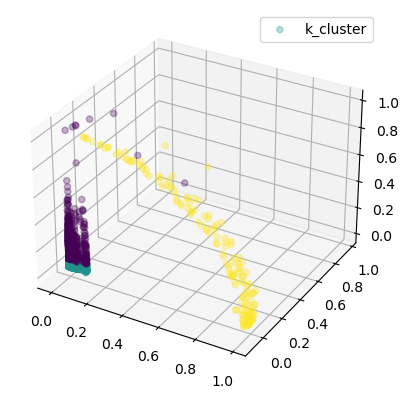

In [186]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data = to_cluster, xs = 'comp_1_', ys = 'comp_2_', zs = 'Count', c = 'k_cluster', alpha = 0.3, label = 'k_cluster')
ax.legend()

Earlier analysis found more interesting relationships focusing on the morning rush hour so try that with clustering.  Drop na before standardising then add the clusters back to the original data i.e. so the means we get of clusters are not standardised and make more sense. Try both 2 and 3 as these seem to be most sensible

In [187]:
morn_cont = morn_rush[['UnqID', 'Datetime', 'temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied','Count']]
morn_cont = morn_cont.set_index(['UnqID', 'Datetime'])
morn_cont = morn_cont.dropna()

morn_cont_std = standardise(morn_cont, morn_cont.columns)
morn_cont_std = morn_cont_std.drop(['wind_speeed'], axis = 1)

pca = PCA(n_components = 2)
comps =  pca.fit_transform(morn_cont_std[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied']])
morn_cont_std[["comp_1", "comp_2"]] = comps



In [188]:
two_clus = KMeans(n_clusters = 2, n_init = 10)
two_clus.fit(morn_cont_std[['comp_1', 'comp_2', 'Count']])
tc_labels = two_clus.labels_
morn_cont['cluster'] = tc_labels
morn_cont.cluster.value_counts()

cluster
0    4923
1     666
Name: count, dtype: int64

In [191]:
three_clus = KMeans(n_clusters = 3, n_init = 10)
three_clus.fit(morn_cont_std[['comp_1', 'comp_2', 'Count']])
thrc_labels = three_clus.labels_
morn_cont['three_cluster'] = thrc_labels
morn_cont.three_cluster.value_counts()

three_cluster
1    4414
0    1014
2     161
Name: count, dtype: int64

Check the sites again, same issue

In [197]:
site_check_3 = pd.merge(morn_cont.loc[(morn_cont.cluster ==1) | (morn_cont.three_cluster.isin([0,2]))].UnqID.value_counts(), 
    locations[['Site ID', 'Location description']], left_index = True, right_on = 'Site ID')

site_check_3

,count,Site ID,Location description
6,19,CENCY007,Albert Embankment (south of Salamanca Street)
14,18,CENCY015,Millbank (north of Great Peter Street)
65,17,CENCY066,Farringdon Road (near station)
16,17,CENCY017,Waterloo Bridge
0,16,CENCY001,Millbank (south of Thorney Street)
...,...,...,...
353,1,CGRCY111,Appold Street
354,1,CGRCY112,Aldgate High Street
264,1,CGRCY022,Crawford Street (east)
278,1,CGRCY036,New Bond Street


What if we focus on the busiest sites so the location doesn't dominate

In [201]:
total_count_per_site = pd.DataFrame(
    data.groupby(['UnqID']).Count.sum().sort_values(ascending = False))
busiest_sites = pd.merge(total_count_per_site[:10], locations['Location description'], left_index = True, right_index = True)
busiest_sites

,Count,Location description
UnqID,,
CENCY015,111956.0,Millbank (north of Great Peter Street)
CENCY017,113131.0,Waterloo Bridge
CENCY029,137882.0,Temple
CENCY030,151748.0,Blackfriars Bridge
CENCY031,117420.0,London Bridge
CENCY032,114062.0,Borough High Street
CENCY039,130140.0,Gracechurch Street
CENCY044,145917.0,New Bridge Street
CENCY052,110552.0,Theobald's Road


Before clustering on this data, look at some more basic stats. Focus on morning rush hour and look at qual descriptions - higher counts in better weather although sample sizes are very small

combined_descr
Clouds                         92
Clear                          54
light rain/ drizzle            19
Haze                            7
mod+heavy rain/ snow/ storm     2
Mist                            1
Name: count, dtype: int64

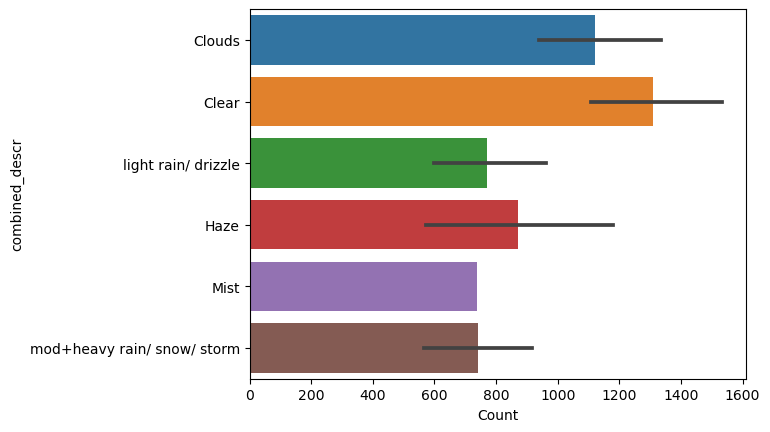

In [204]:
busiest_sites_morn_rush= data.loc[(data.UnqID.isin(busiest_sites.index)) & (data.hour ==8)]
sns.barplot(data = busiest_sites_morn_rush, y = 'combined_descr', x = 'Count')
busiest_sites_morn_rush.combined_descr.value_counts()

Look at darkness - can see  that for all sites it doesn't tell us a great deal when looking by temperature or rain

<Axes: xlabel='temp', ylabel='Count'>

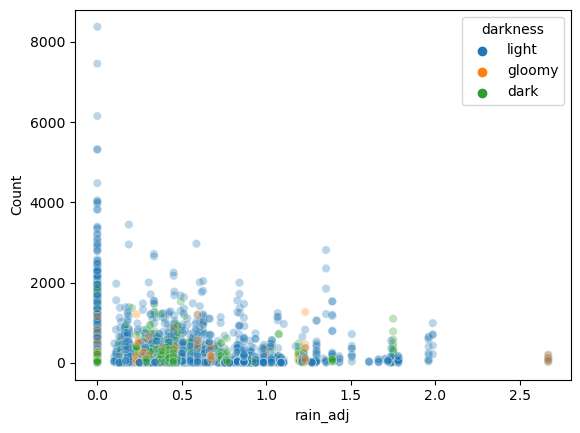

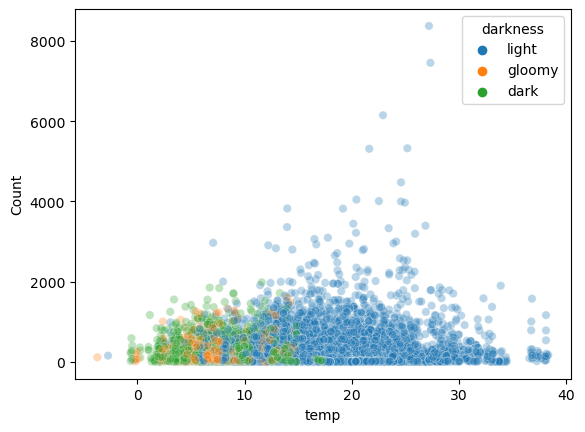

In [206]:
plt.figure()
sns.scatterplot(data = eve_rush, x = 'rain_adj', y = 'Count', hue ='darkness', alpha = 0.3)
plt.figure()
sns.scatterplot(data = eve_rush, x = 'temp', y = 'Count', hue ='darkness', alpha = 0.3)

But what if we focus on the busiest sites - the scatter plots don't show much again (i.e. when looking at other variables) but focusing on darkness alone we can see there are more cycle journeys in the light in evening rush hour

darkness
dark       773.619048
gloomy     718.609756
light     1047.135922
Name: Count, dtype: float64
darkness
dark       773.619048
gloomy     718.609756
light     1047.135922
Name: Count, dtype: float64


[Text(0.5, 0, 'Darkness'), Text(0, 0.5, 'Average cycle count per site')]

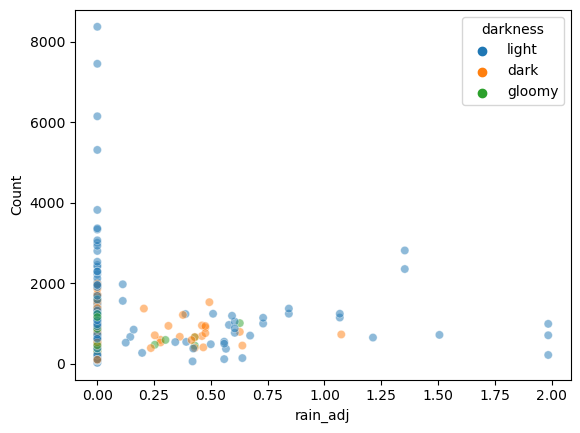

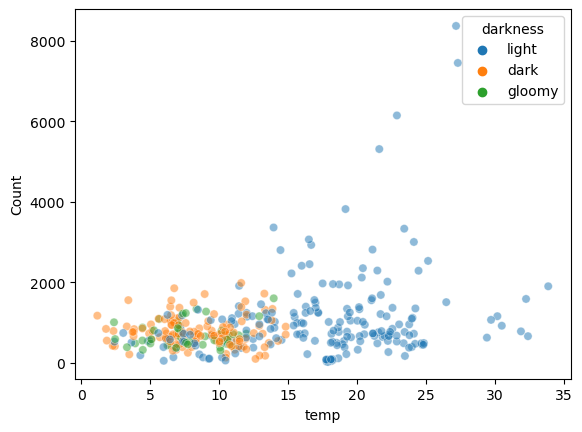

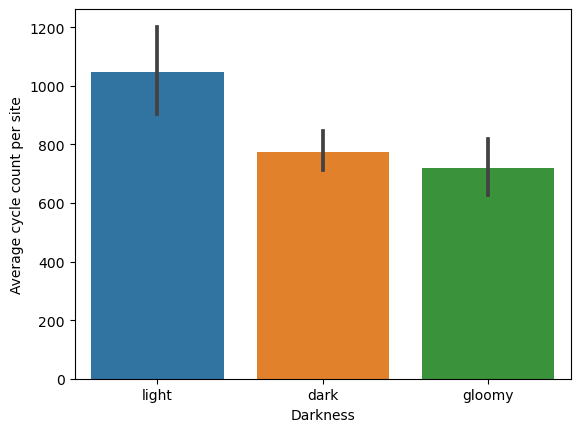

In [209]:
busiest_sites_eve_rush = eve_rush.loc[eve_rush.UnqID.isin(busiest_sites.index)]

plt.figure()
sns.scatterplot(data = busiest_sites_eve_rush, x = 'rain_adj', y = 'Count', hue ='darkness', alpha = 0.5)
plt.figure()
sns.scatterplot(data = busiest_sites_eve_rush, x = 'temp', y = 'Count', hue ='darkness', alpha = 0.5)
print(busiest_sites_eve_rush.groupby('darkness').Count.mean())
print(busiest_sites_eve_rush.groupby('darkness').Count.mean())
plt.figure()
sns.barplot(data = busiest_sites_eve_rush, x = 'darkness', y = 'Count').set(
    xlabel = 'Darkness', ylabel = 'Average cycle count per site')

Try and cluster this data but the minority cluster only contains 12 records, not very helpful

In [210]:
busiest_sites_er_for_clus = standardise(
    busiest_sites_eve_rush[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied', 'Count']].dropna(), 
    [['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied']])
busy_comps =  pca.fit_transform(
    busiest_sites_er_for_clus[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied']])
busiest_sites_er_for_clus[["comp_1", "comp_2"]] = busy_comps
for i in range(2,11):
    busy_clus = KMeans(n_clusters = i, n_init = 10)
    busy_clus.fit(busiest_sites_er_for_clus[['comp_1', 'comp_2', 'Count']])
    bc_labels = busy_clus.labels_
    busiest_sites_er_for_clus['cluster'] = bc_labels
    score = silhouette_score(busiest_sites_er_for_clus[['comp_1', 'comp_2', 'Count']],bc_labels, metric='euclidean')
    print(i, "Score=", score)




2 Score= 0.7616803699299945
3 Score= 0.8112530087881323
4 Score= 0.6226058800752047
5 Score= 0.542399737486345
6 Score= 0.546120601553432
7 Score= 0.483908173102238
8 Score= 0.50144595565855
9 Score= 0.49058438045204583
10 Score= 0.5068781443058801


Set up model with k = 3

In [211]:
busy_clus = KMeans(n_clusters = 3, n_init = 10)
busy_clus.fit(busiest_sites_er_for_clus[['comp_1', 'comp_2', 'Count']])
bc_labels = busy_clus.labels_
busiest_sites_er_for_clus['cluster'] = bc_labels
busiest_sites_er_for_clus.cluster.value_counts()


cluster
0    337
1     17
2      7
Name: count, dtype: int64

In [217]:
print(busiest_sites_er_for_clus.loc[busiest_sites_er_for_clus.cluster == 0].drop(
    ['comp_1', 'comp_2', 'cluster', 'cluster_2'], axis = 1).mean())
print(busiest_sites_er_for_clus.loc[busiest_sites_er_for_clus.cluster.isin([1,2])].drop(
    ['comp_1', 'comp_2', 'cluster', 'cluster_2'], axis = 1).mean())

temp                   12.871691
rain_adj                0.103561
wind_speed              4.988487
tidied_clouds          38.842730
visibility_tidied    9985.163205
Count                 779.106825
dtype: float64
temp                   18.280000
rain_adj                0.136077
wind_speed              5.188750
tidied_clouds          60.416667
visibility_tidied    8750.000000
Count                2865.750000
dtype: float64


Suggests higher cycling counts in morning rush hour at higher temperatures although very small sample size, with the majority cluster dominating, and rainfall is actually higher

and 2 as a check

In [213]:
busy_clus_ = KMeans(n_clusters = 2, n_init = 10)
busy_clus_.fit(busiest_sites_er_for_clus[['comp_1', 'comp_2', 'Count']])
bc_labels_ = busy_clus_.labels_
busiest_sites_er_for_clus['cluster_2'] = bc_labels_
busiest_sites_er_for_clus.cluster_2.value_counts()


cluster_2
0    344
1     17
Name: count, dtype: int64

Look at the means again -  similar story with repsect to temperature, a bigger difference for rainfall. Clearly higher rainfall isn't going to mean 5* as many people cycle therefore this clustering is of limited value.

In [218]:
print(busiest_sites_er_for_clus.loc[busiest_sites_er_for_clus.cluster_2 == 0].drop(
    ['comp_1', 'comp_2', 'cluster', 'cluster_2'], axis = 1).mean())
print(busiest_sites_er_for_clus.loc[busiest_sites_er_for_clus.cluster_2 == 1].drop(
    ['comp_1', 'comp_2', 'cluster', 'cluster_2'], axis = 1).mean())

temp                   12.849709
rain_adj                0.103078
wind_speed              4.967791
tidied_clouds          39.418605
visibility_tidied    9898.255814
Count                 776.337209
dtype: float64
temp                    20.951765
rain_adj                 0.159251
wind_speed               5.690000
tidied_clouds           57.647059
visibility_tidied    10000.000000
Count                 3781.000000
dtype: float64


In [219]:
busiest_sites_mr_for_clus = standardise(
    busiest_sites_morn_rush[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied', 'Count']].dropna(), 
    [['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied']])
busy_morn_comps =  pca.fit_transform(
    busiest_sites_mr_for_clus[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied']])
busiest_sites_mr_for_clus[["comp_1", "comp_2"]] = busy_morn_comps

busy_morn_clus = KMeans(n_clusters = 2, n_init = 10)
busy_morn_clus.fit(busiest_sites_mr_for_clus[['comp_1', 'comp_2', 'Count']])
bc_morn_labels = busy_morn_clus.labels_
busiest_sites_mr_for_clus['cluster'] = bc_morn_labels
busiest_sites_mr_for_clus.cluster.value_counts()
print(busiest_sites_mr_for_clus.loc[busiest_sites_mr_for_clus.cluster == 0].mean(), "\n")
print(busiest_sites_mr_for_clus.loc[busiest_sites_mr_for_clus.cluster == 1].mean())


temp                   10.316809
rain_adj                0.063030
wind_speed              4.279078
tidied_clouds          51.382979
visibility_tidied    9829.787234
Count                1158.234043
comp_1               -681.638401
comp_2                 -1.028214
cluster                 0.000000
dtype: float64 

temp                    7.984762
rain_adj                0.080222
wind_speed              2.922381
tidied_clouds          52.142857
visibility_tidied    4571.428571
Count                 979.000000
comp_1               4576.714979
comp_2                  6.903720
cluster                 1.000000
dtype: float64


Now try morning rush hour. 2 clusters doesn't help much initially as counts are similar, so try and cluster all variables rather than using PCA. To do this, create a separate dataframe of continuous variables that can be standardised then put clusters into original morning rush hour df once done (after first establishing k = 2 is best)

In [220]:
for i in range(2,11):
    df = busiest_sites_morn_rush[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied', 'Count']] .dropna()
    busy_morn_clus_2 = KMeans(n_clusters = i, n_init = 10)
    busy_morn_clus_2.fit(df)
    bc_morn_2_labels = busy_morn_clus_2.labels_
    score = silhouette_score(df, bc_morn_2_labels)
    print(i, "Score=", score)

busy_morn_clus_df = busiest_sites_morn_rush[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied', 'Count']] .dropna()
busy_morn_clus_std = busy_morn_clus_df.copy() 
busy_morn_clus_std = standardise(busy_morn_clus_std, busy_morn_clus_std.columns)
busy_morn_clus_2 = KMeans(n_clusters = 2, n_init = 10)
busy_morn_clus_2.fit(busy_morn_clus_std)
bc_morn_2_labels = busy_morn_clus_2.labels_
busy_morn_clus_df['cluster'] = bc_morn_2_labels
busy_morn_clus_df['rain'] = busy_morn_clus_df.rain_adj ** 3

2 Score= 0.7697975523229285
3 Score= 0.5259399264978327
4 Score= 0.5563819132088812
5 Score= 0.5457791555706052
6 Score= 0.5527985164302983
7 Score= 0.48123390791193804
8 Score= 0.4817820255524544
9 Score= 0.49614151936430967
10 Score= 0.5018450218801607
cluster sizes 118 44


Check the cluster sizes and means - looks to be some slight differences with higher temps and lower rain associated with higher counts in cluster 1, although sample sizes are very small. 

In [222]:
busy_morn_clus_0 = busy_morn_clus_df.loc[busy_morn_clus_df.cluster == 0]
busy_morn_clus_1 = busy_morn_clus_df.loc[busy_morn_clus_df.cluster == 1]
print("cluster sizes", len(busy_morn_clus_0), len(busy_morn_clus_1))
print("cluster 0 means", "\n", busy_morn_clus_0.mean(), "\n\n", "cluster 1 means", "\n", busy_morn_clus_1.mean())
print(len(busy_morn_clus_df.loc[busy_morn_clus_df.rain_adj > 0]))
print(len(busy_morn_clus_0.loc[busy_morn_clus_0.rain_adj >0] ))
print(len(busy_morn_clus_1.loc[busy_morn_clus_1.rain_adj >0] ))

cluster sizes 118 44
cluster 0 means 
 temp                    9.540169
rain_adj                0.085553
wind_speed              4.053559
tidied_clouds          53.050847
visibility_tidied    9050.847458
Count                 761.398305
cluster                 0.000000
rain                    0.093891
dtype: float64 

 cluster 1 means 
 temp                   11.286591
rain_adj                0.010833
wind_speed              4.236364
tidied_clouds          47.272727
visibility_tidied    9409.090909
Count                2136.931818
cluster                 1.000000
rain                    0.000930
dtype: float64
21
19
2


Show these differences on a graph and check means are sig - pvalues of 0.06 i.e. would be significant at 10% level but not 5%

/var/folders/mn/vlrzh77x3js88tqj0c63hvbr0000gn/T/ipykernel_31991/2591178363.py:10: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


TtestResult(statistic=-1.877918305004132, pvalue=0.06221203280893015, df=160.0)
TtestResult(statistic=1.8619051562276459, pvalue=0.06445055912038605, df=160.0)


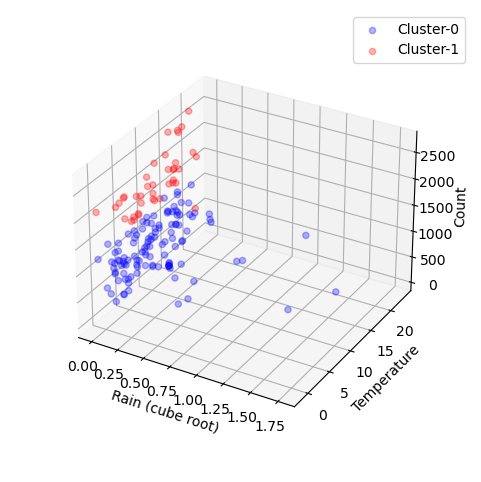

In [224]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')

scat_0 = ax.scatter(data = busy_morn_clus_0.loc[busy_morn_clus_0.Count< 2700], xs = 'rain_adj', ys = 'temp', zs = 'Count', c = 'blue',
           alpha = 0.3)
scat_1 = ax.scatter(data = busy_morn_clus_1.loc[busy_morn_clus_1.Count< 2700], xs = 'rain_adj', ys = 'temp', zs = 'Count', c = 'red',
           alpha = 0.3)
ax.set(xlabel = 'Rain (cube root)', ylabel = 'Temperature', zlabel = 'Count')
ax.legend([scat_0, scat_1], ["Cluster-0", "Cluster-1"])
ax.dist = 12

test_temp = ttest_ind(busy_morn_clus_0.temp, busy_morn_clus_1.temp)
test_rain = ttest_ind(busy_morn_clus_0.rain_adj, busy_morn_clus_1.rain_adj)
print(test_temp)
print(test_rain)